# **Early Sepsis Risk Prediction in ICU Using Machine Learning Models**

**Objective:**

This project aims to develop and validate a predictive model for early sepsis risk in ICU patients using routinely collected clinical data from the first 24 hours in ICU.

## **Import Libraries**

In [ ]:
!pip install optuna
!pip install dalex
!pip install scikit-plot
!pip install shap
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.2-py3-none-any.whl size=1042898 sha256=646d954ff5fe3c4507d2a846991ad9153ce69c82a36cb958e356afff3401e927
  Stored in directory: /root/.cache/pip/wheels/17/0a/3a/8c988bdca6acd7ce4aa949726b26c382ad1635e065bf83a175
Successfully built dalex
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7002cc88d46491519f10056020981aefb9769f7beb0cbfb2a9b7ee35cfa063d6
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
!pip install --upgrade xgboost shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import dalex as dx
import shap
from lime.lime_tabular import LimeTabularExplainer
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score

# Set the maximum number of columns and rows to display to a large number
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

## **Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TUGAS/FINAL PROJECT DS - Yodha Pranata/final_df_sepsis.csv")

In [ ]:
df.head(10)

,Patient_ID,Age_first,Gender_first,HospAdmTime_first,Unit1_first,Unit2_first,HR_mean,HR_median,HR_std,HR_min,HR_max,O2Sat_mean,O2Sat_median,O2Sat_std,O2Sat_min,O2Sat_max,Temp_mean,Temp_median,Temp_std,Temp_min,Temp_max,SBP_mean,SBP_median,SBP_std,SBP_min,SBP_max,MAP_mean,MAP_median,MAP_std,MAP_min,MAP_max,DBP_mean,DBP_median,DBP_std,DBP_min,DBP_max,Resp_mean,Resp_median,Resp_std,Resp_min,Resp_max,FiO2_mean,FiO2_median,FiO2_std,FiO2_min,FiO2_max,BaseExcess_mean,BaseExcess_median,BaseExcess_std,BaseExcess_min,BaseExcess_max,BaseExcess_count,HCO3_mean,HCO3_median,HCO3_std,HCO3_min,HCO3_max,HCO3_count,pH_mean,pH_median,pH_std,pH_min,pH_max,pH_count,PaCO2_mean,PaCO2_median,PaCO2_std,PaCO2_min,PaCO2_max,PaCO2_count,SaO2_mean,SaO2_median,SaO2_std,SaO2_min,SaO2_max,SaO2_count,BUN_mean,BUN_median,BUN_std,BUN_min,BUN_max,BUN_count,Creatinine_mean,Creatinine_median,Creatinine_std,Creatinine_min,Creatinine_max,Creatinine_count,Glucose_mean,Glucose_median,Glucose_std,Glucose_min,Glucose_max,Glucose_count,Lactate_mean,Lactate_median,Lactate_std,Lactate_min,Lactate_max,Lactate_count,Potassium_mean,Potassium_median,Potassium_std,Potassium_min,Potassium_max,Potassium_count,Bilirubin_total_mean,Bilirubin_total_median,Bilirubin_total_std,Bilirubin_total_min,Bilirubin_total_max,Bilirubin_total_count,Hct_mean,Hct_median,Hct_std,Hct_min,Hct_max,Hct_count,Hgb_mean,Hgb_median,Hgb_std,Hgb_min,Hgb_max,Hgb_count,WBC_mean,WBC_median,WBC_std,WBC_min,WBC_max,WBC_count,Platelets_mean,Platelets_median,Platelets_std,Platelets_min,Platelets_max,Platelets_count,ICULOS_max,SepsisLabel
0,1,83.14,0,-0.03,NaN,NaN,103.000000,104.00,5.778521,89.0,113.0,91.750000,91.50,2.781929,85.0,99.0,36.595833,36.56,0.469819,36.11,37.17,126.583333,132.000,13.758528,93.0,147.0,86.527083,86.67,7.128399,75.33,96.67,NaN,NaN,NaN,NaN,NaN,25.104167,25.50,4.378751,17.0,32.0,0.280000,0.28,0.000000,0.28,0.28,22.000000,22.0,1.825742,20.0,24.0,4,45.0,45.0,NaN,45.0,45.0,1,7.367500,7.365,0.025000,7.34,7.40,4,93.000000,93.0,6.218253,86.0,100.0,4,85.666667,88.0,6.806859,78.0,91.0,3,14.000000,14.0,NaN,14.0,14.0,1,0.700000,0.70,NaN,0.7,0.7,1,193.000000,193.0,NaN,193.0,193.0,1,NaN,NaN,NaN,NaN,NaN,0,3.800000,3.80,NaN,3.8,3.8,1,0.30,0.30,NaN,0.3,0.3,1,37.200000,37.20,NaN,37.2,37.2,1,12.500000,12.50,NaN,12.5,12.5,1,5.700000,5.70,NaN,5.7,5.7,1,317.000000,317.0,NaN,317.0,317.0,1,24,0
1,2,75.91,0,-98.60,0.0,1.0,60.956522,60.00,7.957148,54.0,94.0,97.086957,97.00,2.130152,94.0,100.0,36.181739,36.11,0.154174,36.00,36.44,129.173913,124.000,19.267618,114.0,194.0,66.630435,65.00,14.386087,50.50,116.00,41.565217,41.0,6.801244,36.0,66.0,14.608696,13.00,4.311603,9.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,22.0,22.0,NaN,22.0,22.0,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,100.000000,100.0,NaN,100.0,100.0,1,2.500000,2.50,NaN,2.5,2.5,1,78.000000,78.0,NaN,78.0,78.0,1,NaN,NaN,NaN,NaN,NaN,0,5.100000,5.10,NaN,5.1,5.1,1,NaN,NaN,NaN,NaN,NaN,0,27.800000,27.80,NaN,27.8,27.8,1,9.700000,9.70,NaN,9.7,9.7,1,11.000000,11.00,NaN,11.0,11.0,1,158.000000,158.0,NaN,158.0,158.0,1,23,0
2,3,45.82,0,-1195.71,1.0,0.0,82.750000,83.00,6.817497,68.0,93.0,95.583333,95.75,1.290994,93.0,98.0,37.563333,37.28,0.598089,37.06,38.61,138.625000,138.000,8.786415,122.0,155.0,77.728750,77.50,7.581409,62.67,93.50,51.833333,50.5,4.020779,44.0,62.5,26.125000,26.00,5.320694,17.0,40.0,0.658333,0.70,0.147196,0.50,0.80,8.000000,8.0,NaN,8.0,8.0,1,31.5,31.5,0.707107,31.0,32.0,2,7.510000,7.510,NaN,7.51,7.51,1,41.000000,41.0,NaN,41.0,41.0,1,NaN,NaN,NaN,NaN,NaN,0,30.500000,30.5,0.707107,30.0,31.0,2,0.900000,0.90,0.000000,0.9,0.9,2,82.000000,82.0,43.840620,51.0,113.0,2,NaN,NaN,NaN,NaN,NaN,0,3.800000,3.80,0.000000,3.8,3.8,2,NaN,NaN,NaN,NaN,NaN,0,26.550000,26.55,0.494975,26.2,26.9,2,8.950000,8.95,0.212132,8.8,9.1,2,9.150000,9.15,1.202082,8.3,10.0,2,476.500000,476.5,16.263456,465.0,488.0,2,24,0
3,4,65.71,0,-8.77,0.0,1.0,101.312500,102.75,5.935912,93.0,113.0,98.104167,98.00,1.539192,95.5,100.0,36.418750,36.39,0.249979,36.06,36.78,111.79166

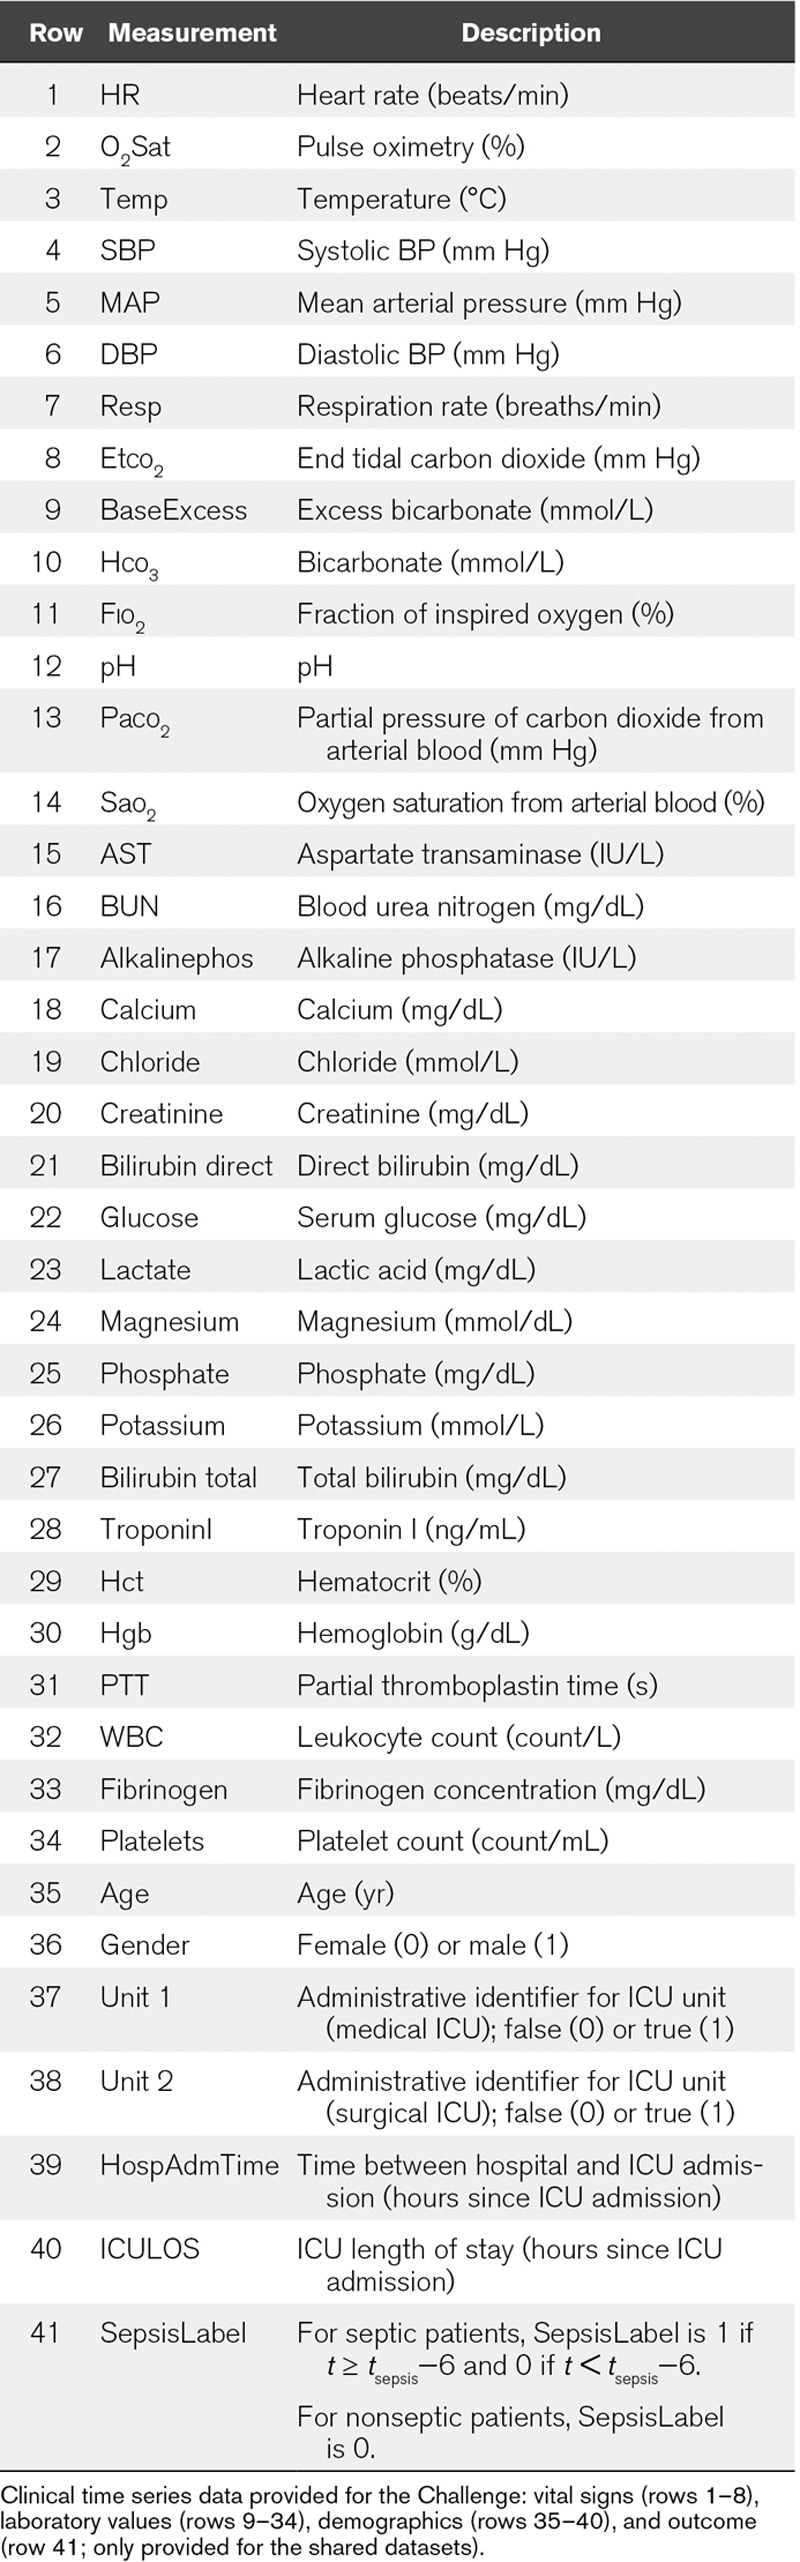

In [ ]:
df.info(max_cols=150, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40321 entries, 0 to 40320
Data columns (total 138 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    Patient_ID              40321 non-null  int64  
 1    Age_first               40321 non-null  float64
 2    Gender_first            40321 non-null  int64  
 3    HospAdmTime_first       40320 non-null  float64
 4    Unit1_first             24711 non-null  float64
 5    Unit2_first             24711 non-null  float64
 6    HR_mean                 40316 non-null  float64
 7    HR_median               40316 non-null  float64
 8    HR_std                  40315 non-null  float64
 9    HR_min                  40316 non-null  float64
 10   HR_max                  40316 non-null  float64
 11   O2Sat_mean              40296 non-null  float64
 12   O2Sat_median            40296 non-null  float64
 13   O2Sat_std               40295 non-null  float64
 14   O2Sat_min           

## **Data Cleaning Before Splitting**

In [ ]:
# Cek Missing Value
df.isnull().sum()

,0
Patient_ID,0
Age_first,0
Gender_first,0
HospAdmTime_first,1
Unit1_first,15610
Unit2_first,15610
HR_mean,5
HR_median,5
HR_std,6
HR_min,5


In [ ]:
#cek duplicate

df.duplicated().sum()

np.int64(0)

In [ ]:
# ganti label sepsis label dengan Yes/No
# ganti label agar mudah informasi yang didapat saat EDA

df['SepsisLabel'] = df['SepsisLabel'].replace({0: 'No', 1: 'Yes'})

In [ ]:
# Ganti lebel gender dengan  female or male

df['Gender_first'] = df['Gender_first'].replace({0: 'Female', 1: 'Male'})

In [ ]:
df['ICU_Unit'] = np.select(
    [
        (df['Unit1_first'] == 1) & (df['Unit2_first'] != 1),  # MICU
        (df['Unit2_first'] == 1) & (df['Unit1_first'] != 1),  # SICU
    ],
    ['MICU', 'SICU'],
    default='Unknown'
)

#Drop Kolom Unit First

df.drop(columns=['Unit1_first', 'Unit2_first'], inplace=True)

## **Exploratory Data Analysis**

In [ ]:
#copy dataset untuk EDA

df_eda = df.copy()

In [ ]:
#Handling Missing Value

vital_prefixes = ['HR_', 'O2Sat_', 'Temp_', 'SBP_', 'MAP_', 'DBP_', 'Resp_']

vital_cols = [
    c for c in df_eda.columns
    if any(c.startswith(p) for p in vital_prefixes)
]

# Imputasi median per kolom
for col in vital_cols:
    df_eda[col] = df_eda[col].fillna(df_eda[col].median())

Missing Value data di handling dengan inputasi Median karena kebanyakan feature datanya tidak terdistribusi normal karena dilihat dari mean dan median masing feature terpaut jauh

In [ ]:
#Handling Missing Value HospAdmTime

df_eda['HospAdmTime_first'] = df_eda['HospAdmTime_first'].fillna(df_eda['HospAdmTime_first'].median())

In [ ]:
df_eda.describe()

,Patient_ID,Age_first,HospAdmTime_first,HR_mean,HR_median,HR_std,HR_min,HR_max,O2Sat_mean,O2Sat_median,O2Sat_std,O2Sat_min,O2Sat_max,Temp_mean,Temp_median,Temp_std,Temp_min,Temp_max,SBP_mean,SBP_median,SBP_std,SBP_min,SBP_max,MAP_mean,MAP_median,MAP_std,MAP_min,MAP_max,DBP_mean,DBP_median,DBP_std,DBP_min,DBP_max,Resp_mean,Resp_median,Resp_std,Resp_min,Resp_max,FiO2_mean,FiO2_median,FiO2_std,FiO2_min,FiO2_max,BaseExcess_mean,BaseExcess_median,BaseExcess_std,BaseExcess_min,BaseExcess_max,BaseExcess_count,HCO3_mean,HCO3_median,HCO3_std,HCO3_min,HCO3_max,HCO3_count,pH_mean,pH_median,pH_std,pH_min,pH_max,pH_count,PaCO2_mean,PaCO2_median,PaCO2_std,PaCO2_min,PaCO2_max,PaCO2_count,SaO2_mean,SaO2_median,SaO2_std,SaO2_min,SaO2_max,SaO2_count,BUN_mean,BUN_median,BUN_std,BUN_min,BUN_max,BUN_count,Creatinine_mean,Creatinine_median,Creatinine_std,Creatinine_min,Creatinine_max,Creatinine_count,Glucose_mean,Glucose_median,Glucose_std,Glucose_min,Glucose_max,Glucose_count,Lactate_mean,Lactate_median,Lactate_std,Lactate_min,Lactate_max,Lactate_count,Potassium_mean,Potassium_median,Potassium_std,Potassium_min,Potassium_max,Potassium_count,Bilirubin_total_mean,Bilirubin_total_median,Bilirubin_total_std,Bilirubin_total_min,Bilirubin_total_max,Bilirubin_total_count,Hct_mean,Hct_median,Hct_std,Hct_min,Hct_max,Hct_count,Hgb_mean,Hgb_median,Hgb_std,Hgb_min,Hgb_max,Hgb_count,WBC_mean,WBC_median,WBC_std,WBC_min,WBC_max,WBC_count,Platelets_mean,Platelets_median,Platelets_std,Platelets_min,Platelets_max,Platelets_count,ICULOS_max
count,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.00000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,40321.000000,16756.000000,16756.000000,16756.000000,16756.000000,16756.000000,12496.000000,12496.000000,10382.000000,12496.000000,12496.000000,40321.000000,19759.000000,19759.000000,11682.000000,19759.000000,19759.000000,40321.000000,17792.000000,17792.000000,13134.000000,17792.000000,17792.000000,40321.000000,17268.000000,17268.000000,12319.000000,17268.000000,17268.000000,40321.000000,11875.00000,11875.000000,7762.000000,11875.000000,11875.000000,40321.000000,37338.000000,37338.00000,17790.000000,37338.000000,37338.000000,40321.000000,37257.000000,37257.000000,15586.000000,37257.000000,37257.000000,40321.000000,38210.000000,38210.000000,28093.000000,38210.000000,38210.000000,40321.000000,11317.000000,11317.000000,6545.000000,11317.000000,11317.000000,40321.000000,37604.000000,37604.000000,22816.000000,37604.000000,37604.000000,40321.000000,12382.000000,12382.000000,2354.000000,12382.000000,12382.000000,40321.000000,36980.000000,36980.000000,20819.000000,36980.000000,36980.000000,40321.000000,36673.000000,36673.000000,18304.000000,36673.000000,36673.000000,40321.000000,36425.000000,36425.000000,15749.000000,36425.000000,36425.000000,40321.000000,36469.000000,36469.000000,14713.000000,36469.000000,36469.000000,40321.000000,40321.000000
mean,59684.085489,61.640599,-51.844257,83.828744,83.337380,7.595463,71.818556,98.639300,97.322935,97.604077,1.754111,93.260931,99.453511,36.807996,36.832756,0.393737,36.181476,37.341362,122.904095,122.506253,13.045594,100.056098,148.026338,82.45810,81.908488,9.324523,66.757310,101.950493,63.941103,63.302688,7.446840,51.789702,79.931821,18.351385,18.133256,3.182392,13.216940,24.783618,0.557478,0.500911,0.166192,0.451015,0.915609,-0.666739,-0.634417,1.515616,-2.166761,0.753341,1.425039,24.117814,24.130363,1.168422,23.517306,24.696493,1.007688,7.378238,7.378961,0.039492,7.343159,7.410891,1.813497,40.920850,40.790543,4.454468,37.546476,44.674861,1.477369,93.56403,94.279939,4.797134,89.279461,96.053486,0.933633,22.124932,22.11

In [ ]:
df_eda.describe(include='object')

,Gender_first,SepsisLabel,ICU_Unit
count,40321,40321,40321
unique,2,2,3
top,Male,No,Unknown
freq,22559,37390,15610


In [ ]:
categorical_column = df_eda.select_dtypes(include=['object']).columns

for column in categorical_column:
    print(f"============= {column} ===============")
    display(df_eda[column].value_counts())
    print()

============= Gender_first ===============


,count
Gender_first,
Male,22559
Female,17762



============= SepsisLabel ===============


,count
SepsisLabel,
No,37390
Yes,2931



============= ICU_Unit ===============


,count
ICU_Unit,
Unknown,15610
SICU,12446
MICU,12265


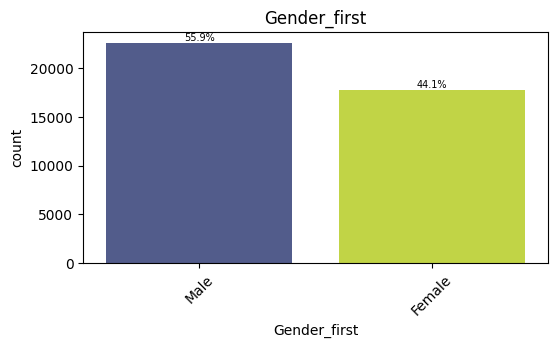

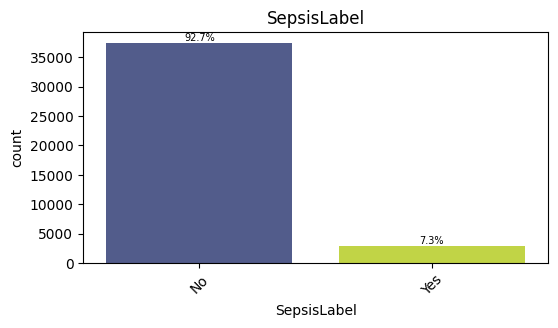

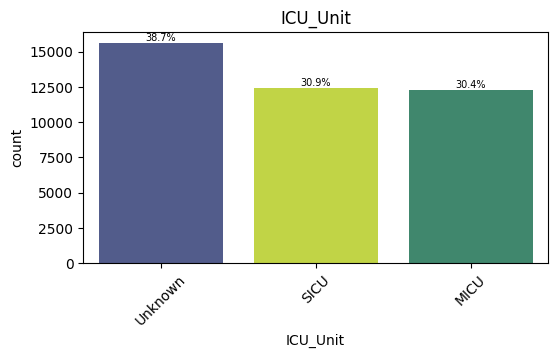

In [ ]:
kolom_kategorik = df_eda.select_dtypes(include=['object']).columns
palette = ['#485695', '#d2ec2e', '#349370']
for col in kolom_kategorik:
    plt.figure(figsize=(6,3))
    #mengurutkan kategori berdasarkan presentase
    order = df_eda[col].value_counts().index

    ax = sns.countplot(x=df_eda[col],order=order, palette= palette)
    plt.title(f'{col}')
    plt.xticks(rotation=45)

    total = len(df_eda)

    for p in ax.patches:
        percent = 100 * p.get_height() / total
        ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=7, color='black')
    plt.show()

- ICU unit labels are split into Unknown (38.7%), SICU (30.9%), and MICU (30.4%).
- The target label is highly imbalanced, with 92.7% non-sepsis and only 7.3% sepsis cases.
- The dataset consists of 55.9% males and 44.1% females.


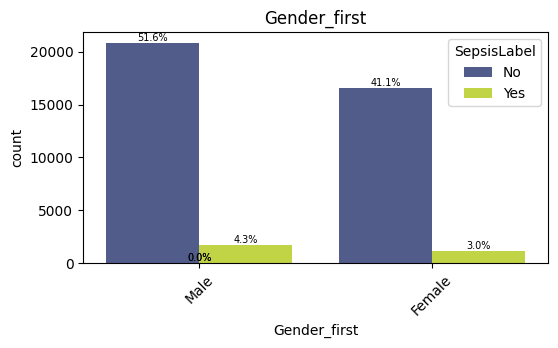

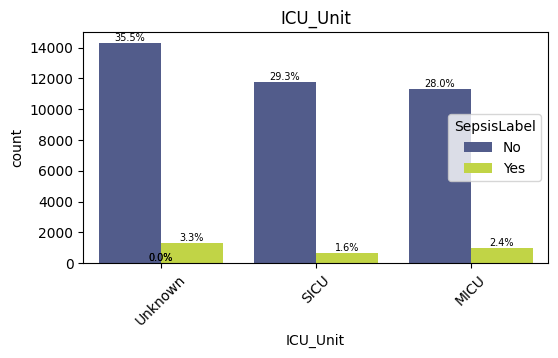

In [ ]:
kategorik = ['Gender_first', 'ICU_Unit']

for col in kategorik:
    plt.figure(figsize=(6,3))
    #mengurutkan kategori berdasarkan presentase
    order = df_eda[col].value_counts().index

    ax = sns.countplot(x=df_eda[col], hue=df_eda['SepsisLabel'], order=order, palette=palette)
    plt.title(f'{col}')
    plt.xticks(rotation=45)

    total = len(df_eda)

    for p in ax.patches:
        percent = 100 * p.get_height() / total
        ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=7, color='black')
    plt.show()

 Sepsis remains rare but is slightly more common in men: 4.3% of males have sepsis versus 3% of females. Non-sepsis accounts for 51.6% of the total sample in males and 41.1% in females.


P-value HR_median vs Sepsis: 0.00


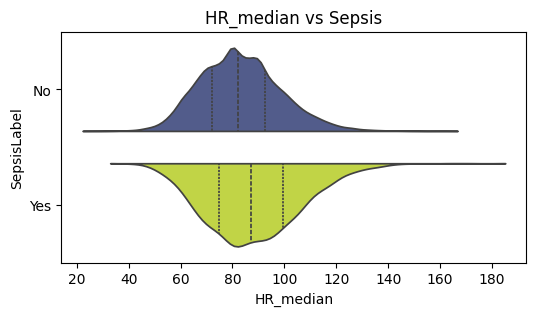

P-value O2Sat_median vs Sepsis: 0.00


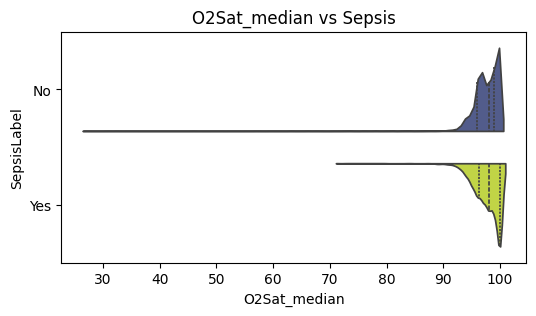

P-value Temp_median vs Sepsis: 0.00


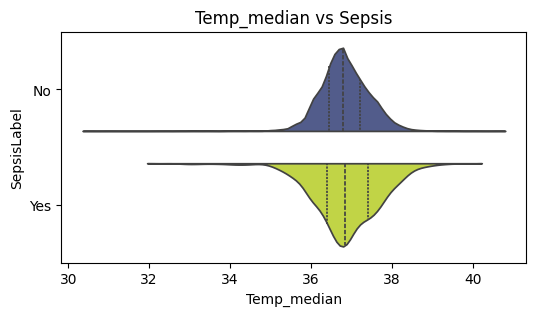

P-value SBP_median vs Sepsis: 0.00


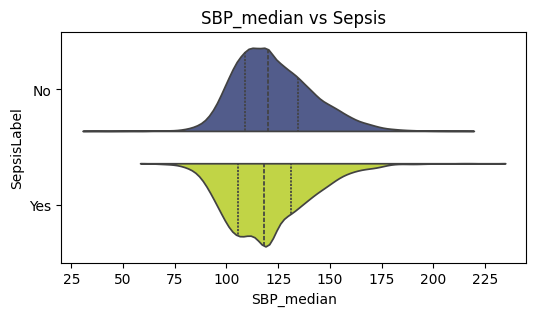

P-value MAP_median vs Sepsis: 0.00


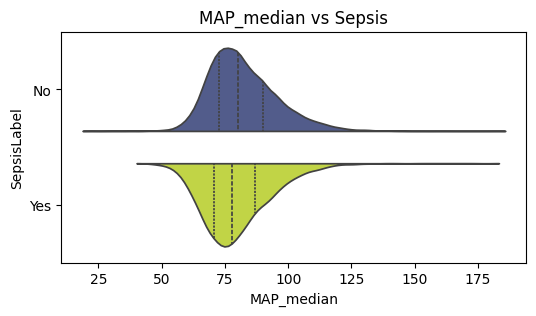

P-value DBP_median vs Sepsis: 0.00


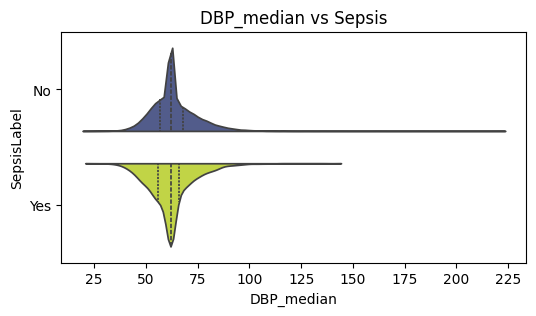

P-value Resp_median vs Sepsis: 0.00


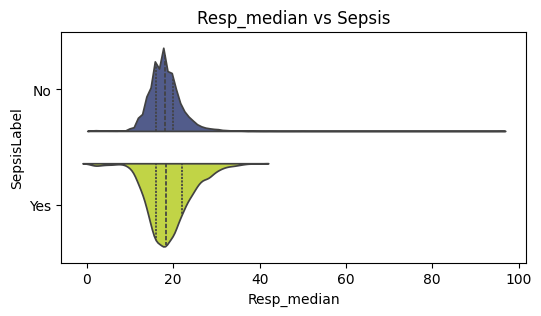

P-value SaO2_median vs Sepsis: 0.02


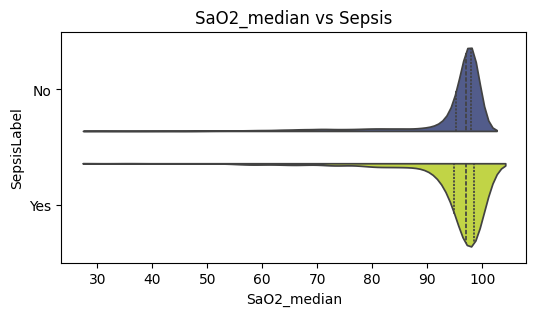

P-value pH_median vs Sepsis: 0.16


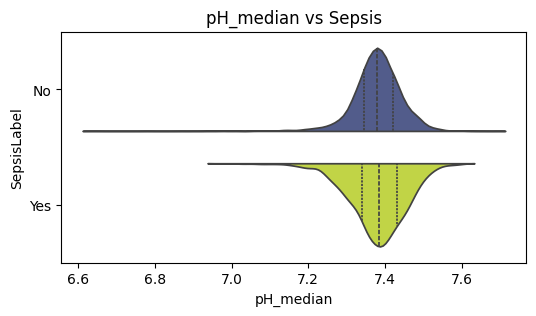

P-value PaCO2_median vs Sepsis: 0.00


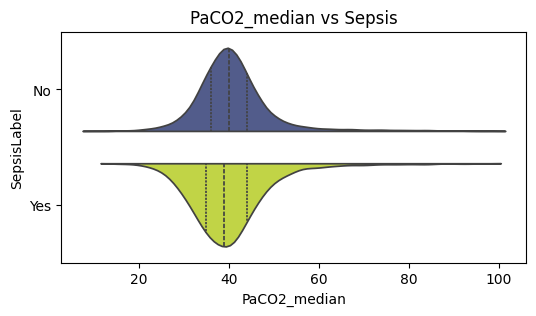

P-value FiO2_median vs Sepsis: 0.00


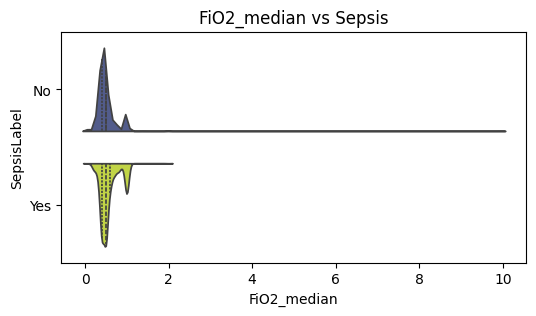

P-value Lactate_median vs Sepsis: 0.00


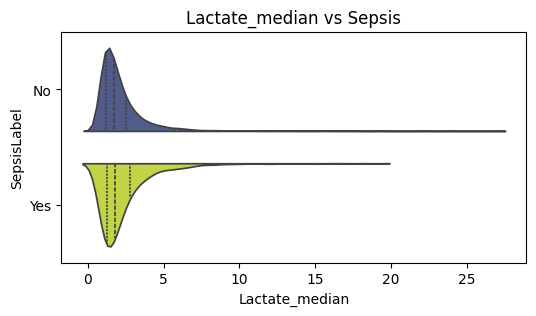

P-value BUN_median vs Sepsis: 0.00


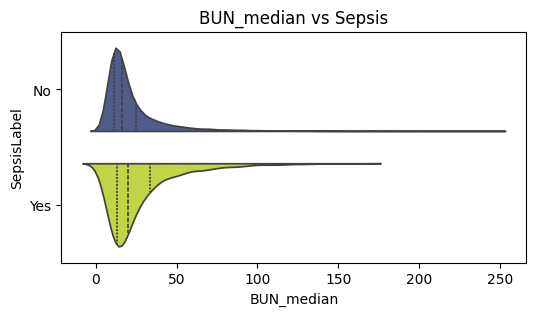

P-value WBC_median vs Sepsis: 0.00


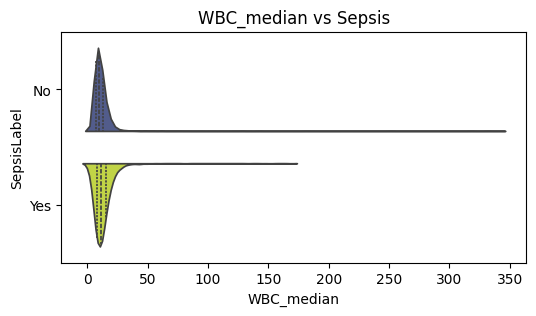

P-value Platelets_median vs Sepsis: 0.00


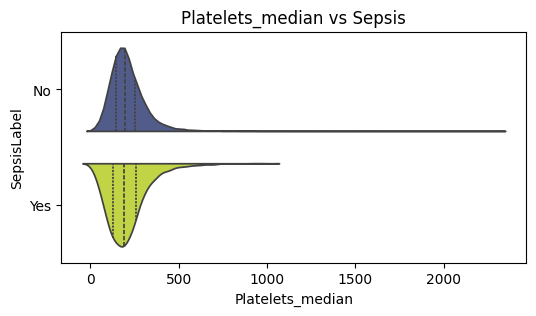

P-value Bilirubin_total_median vs Sepsis: 0.00


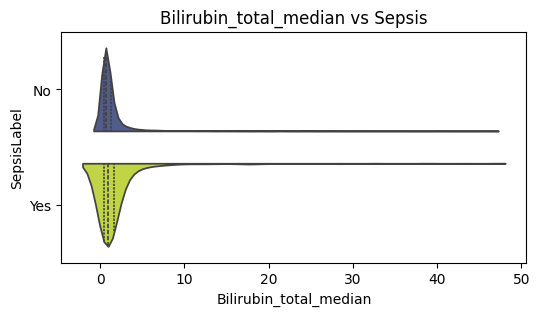

P-value Creatinine_median vs Sepsis: 0.00


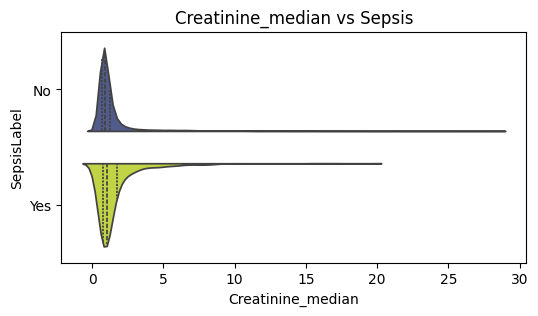

P-value Age_first vs Sepsis: 0.12


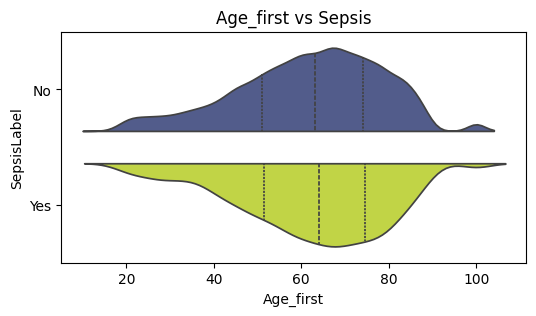

P-value HospAdmTime_first vs Sepsis: 0.00


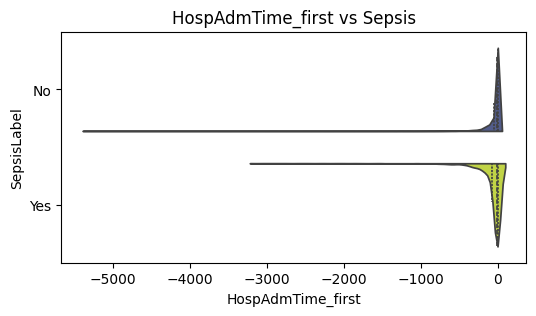

In [ ]:
#Violin plot numeric vs categoric
from scipy.stats import mannwhitneyu

numeric_columns = ['HR_median', 'O2Sat_median', 'Temp_median',
                   'SBP_median', 'MAP_median', 'DBP_median', 'Resp_median',
                   'SaO2_median', 'pH_median', 'PaCO2_median', 'FiO2_median', 'Lactate_median',
                   'BUN_median', 'WBC_median', 'Platelets_median', 'Bilirubin_total_median',
                   'Creatinine_median', 'Age_first', 'HospAdmTime_first']

for col in numeric_columns:
    yes = df_eda[df_eda.SepsisLabel=="Yes"][col].dropna()
    no  = df_eda[df_eda.SepsisLabel=="No"][col].dropna()
    res = mannwhitneyu(yes, no, alternative = 'two-sided')
    print(f'P-value {col} vs Sepsis: {res.pvalue:.2f}')

    plt.figure(figsize=(6,3))
    sns.violinplot(data = df_eda,
    x = col,
    y = 'SepsisLabel',
    split = True,
    inner = 'quart',
    gap = 0.1,
    palette = palette)


    plt.title(f'{col} vs Sepsis')
    plt.show()

Insight:

- The plot shows that HospAdmTime_first is concentrated near 0 for both groups, meaning most patients enter the ICU soon after hospital admission. However, the sepsis group has a much longer negative tail, indicating many sepsis cases had a substantially longer pre-ICU hospital stay. This suggests prolonged hospitalization before ICU admission is associated with higher sepsis risk, likely reflecting hospital-acquired infection or delayed deterioration.
- Most patients cluster around 65–75 years, indicating this is the dominant age band in both groups.The sepsis and non-sepsis age distributions overlap closely with no clear shift in median or spread. The Mann–Whitney U test p = 0.12 confirms that Age_first does not differ significantly between sepsis and non-sepsis patients in this dataset.
- The sepsis group shows shifted and wider distributions for all vitals features(Resp, HR, Temp), indicating early physiologic instability.
HR and RR medians tend to be higher in sepsis patients, while temperature is slightly higher and more variable. Mann–Whitney U p = .00 for HR, RR, and Temp confirms these differences are statistically significant.
- The sepsis group has lower median MAP, SBP, and DBP, with curves shifted left.
The sepsis distributions are wider, indicating early hemodynamic instability/hypotension. Mann–Whitney U test p = .00 confirms these blood-pressure differences are statistically significant.
- pH_median is more variable and slightly lower in the sepsis group, indicating early acid–base disturbance.
- Lactate_median is higher in sepsis, indicating early hyperlactatemia linked to hypoperfusion/shock; non-sepsis stays lower and tighter.

P-value HCO3_count vs Sepsis: 0.00


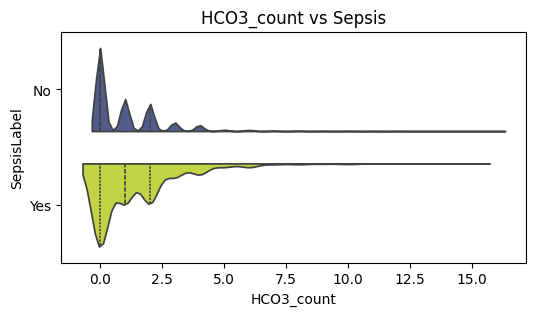

P-value PaCO2_count vs Sepsis: 0.00


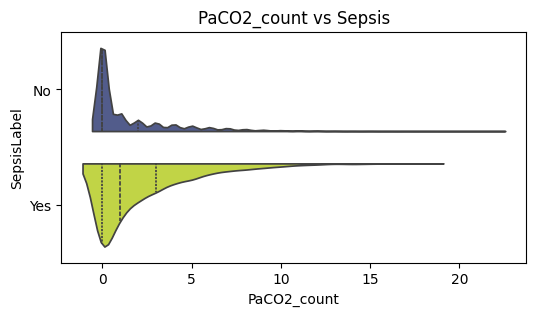

P-value SaO2_count vs Sepsis: 0.00


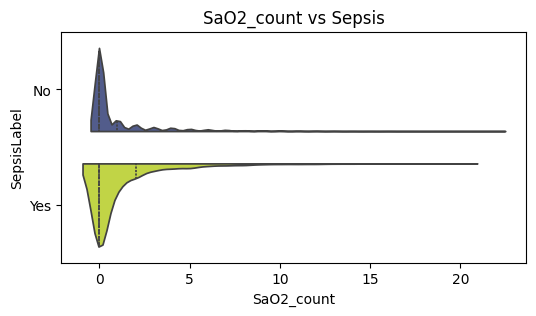

P-value Lactate_count vs Sepsis: 0.00


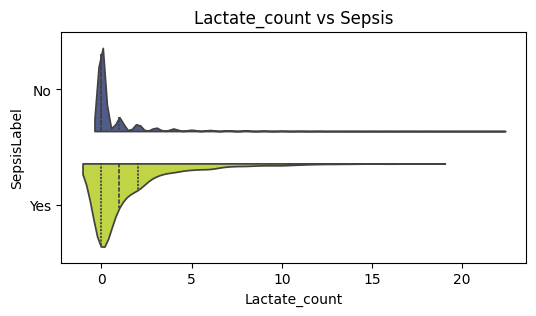

In [ ]:
count_column= ["HCO3_count", "PaCO2_count", "SaO2_count", "Lactate_count"]

for col in count_column:
    yes = df_eda[df_eda.SepsisLabel=="Yes"][col].dropna()
    no  = df_eda[df_eda.SepsisLabel=="No"][col].dropna()
    res = mannwhitneyu(yes, no, alternative = 'two-sided')
    print(f'P-value {col} vs Sepsis: {res.pvalue:.2f}')

    plt.figure(figsize=(6,3))
    sns.violinplot(data = df_eda,
    x = col,
    y = 'SepsisLabel',
    split = True,
    inner = 'quart',
    gap = 0.1,
    palette = palette)


    plt.title(f'{col} vs Sepsis')
    plt.show()

Insight:
- PaCO2_count and SaO2_count are higher in sepsis, suggesting more frequent BGA checks due to instability. Mann–Whitney U p = 0.00 confirms these differences are significant.
- Lactate_count is higher in sepsis, reflecting more frequent monitoring.
Mann–Whitney U p = 0.00 confirms both differences are significant.

## **Split Train and Test**

In [ ]:
#split train dan test

df_pretrain, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_pretrain.shape

(32256, 137)

In [ ]:
df_test.shape

(8065, 137)

In [ ]:
df_pretrain.head()

,Patient_ID,Age_first,Gender_first,HospAdmTime_first,HR_mean,HR_median,HR_std,HR_min,HR_max,O2Sat_mean,O2Sat_median,O2Sat_std,O2Sat_min,O2Sat_max,Temp_mean,Temp_median,Temp_std,Temp_min,Temp_max,SBP_mean,SBP_median,SBP_std,SBP_min,SBP_max,MAP_mean,MAP_median,MAP_std,MAP_min,MAP_max,DBP_mean,DBP_median,DBP_std,DBP_min,DBP_max,Resp_mean,Resp_median,Resp_std,Resp_min,Resp_max,FiO2_mean,FiO2_median,FiO2_std,FiO2_min,FiO2_max,BaseExcess_mean,BaseExcess_median,BaseExcess_std,BaseExcess_min,BaseExcess_max,BaseExcess_count,HCO3_mean,HCO3_median,HCO3_std,HCO3_min,HCO3_max,HCO3_count,pH_mean,pH_median,pH_std,pH_min,pH_max,pH_count,PaCO2_mean,PaCO2_median,PaCO2_std,PaCO2_min,PaCO2_max,PaCO2_count,SaO2_mean,SaO2_median,SaO2_std,SaO2_min,SaO2_max,SaO2_count,BUN_mean,BUN_median,BUN_std,BUN_min,BUN_max,BUN_count,Creatinine_mean,Creatinine_median,Creatinine_std,Creatinine_min,Creatinine_max,Creatinine_count,Glucose_mean,Glucose_median,Glucose_std,Glucose_min,Glucose_max,Glucose_count,Lactate_mean,Lactate_median,Lactate_std,Lactate_min,Lactate_max,Lactate_count,Potassium_mean,Potassium_median,Potassium_std,Potassium_min,Potassium_max,Potassium_count,Bilirubin_total_mean,Bilirubin_total_median,Bilirubin_total_std,Bilirubin_total_min,Bilirubin_total_max,Bilirubin_total_count,Hct_mean,Hct_median,Hct_std,Hct_min,Hct_max,Hct_count,Hgb_mean,Hgb_median,Hgb_std,Hgb_min,Hgb_max,Hgb_count,WBC_mean,WBC_median,WBC_std,WBC_min,WBC_max,WBC_count,Platelets_mean,Platelets_median,Platelets_std,Platelets_min,Platelets_max,Platelets_count,ICULOS_max,SepsisLabel,ICU_Unit
31287,110966,79.00,Female,-51.74,89.000000,91.75,21.315436,58.0,120.0,99.750000,100.0,1.032094,95.0,100.0,36.262500,36.475,0.447517,35.15,36.7,127.312500,130.5,15.347293,99.0,160.0,91.895833,92.50,9.595039,72.0,107.0,68.416667,69.25,7.592426,54.0,83.0,16.062500,13.5,6.245542,10.0,30.0,0.400000,0.4,0.000000,0.40,0.4,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,7.445000,7.445,0.007071,7.44,7.45,2,30.400000,30.4,1.272792,29.5,31.3,2,98.30,98.3,0.141421,98.2,98.4,2,11.00,11.0,NaN,11.0,11.0,1,0.7700,0.77,NaN,0.77,0.77,1,134.333333,137.0,25.656151,79.0,180.0,15,2.825000,2.825,1.534422,1.74,3.91,2,4.008000,4.21,0.456804,3.50,4.40,5,NaN,NaN,NaN,NaN,NaN,0,30.900000,30.90,NaN,30.9,30.9,1,10.300000,10.30,NaN,10.3,10.3,1,11.100,11.1,NaN,11.1,11.1,1,75.00,75.0,NaN,75.0,75.0,1,24,No,SICU
35233,114912,67.00,Female,-3.92,98.750000,96.25,13.393095,83.0,127.5,97.954545,99.5,4.128614,81.0,100.0,35.777273,35.900,0.669706,35.00,36.9,113.386364,114.5,22.288120,83.0,149.0,72.022727,70.25,13.031534,55.0,95.0,59.659091,57.25,9.469734,48.0,76.0,18.954545,18.0,3.933704,15.0,28.0,0.852273,1.0,0.254239,0.35,1.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,7.202000,7.140,0.277254,6.91,7.53,5,37.800000,44.6,16.049299,16.2,54.6,5,94.82,98.4,6.582705,83.6,99.2,5,34.75,34.0,3.095696,32.0,39.0,4,3.2225,3.24,0.125797,3.07,3.34,4,133.142857,124.0,90.633748,13.0,316.0,7,14.146000,15.540,2.435206,10.93,16.34,5,5.083333,4.28,1.752183,3.85,8.35,6,0.1,0.1,0.0,0.1,0.1,2,24.166667,25.05,5.282297,15.9,31.0,6,7.466667,7.65,1.527962,5.0,9.6,6,3.525,1.9,3.594788,1.4,8.9,4,69.75,57.5,52.829127,20.0,144.0,4,22,No,MICU
16723,16734,78.95,Male,-4.37,80.065217,75.00,12.915199,68.0,115.0,97.956522,98.0,1.999506,94.0,100.0,36.354348,36.300,0.402242,35.15,37.1,129.217391,130.5,10.186696,104.0,148.0,82.608696,84.00,5.875520,67.0,90.0,64.021739,65.00,4.289200,53.0,70.0,16.130435,14.0,4.079375,12.0,25.0,0.652174,0.6,0.156291,0.50,1.0,-3.423077,-3.0,1.631029,-6.5,-1.0,13,22.0,22.0,NaN,22.0,22.0,1,7.397692,7.410,0.053721,7.29,7.48,13,32.230769,31.0,4.918568,25.0,41.0,13,86.40,96.5,17.639602,52.0,98.0,10,25.00,25.0,NaN,25.0,25.0,1,1.0000,1.00,NaN,1.00,1.00,1,129.222222,122.0,38.554435,86.0,204.0,9,3.533333,3.600,0.305505,3.20,3.80,3,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,30.314286,30.00,2.560878,27.0,35.0,7,10.157143,10.00,0.869592,9.1,11.8,7,NaN,NaN,NaN,NaN,NaN,0,129.00,129.0,NaN,129.0,129.0,1,24,No,SICU
32024,111703,61.00,Female,-7.08,117.312500,117.50,

In [ ]:
df_pretrain.describe()

,Patient_ID,Age_first,HospAdmTime_first,HR_mean,HR_median,HR_std,HR_min,HR_max,O2Sat_mean,O2Sat_median,O2Sat_std,O2Sat_min,O2Sat_max,Temp_mean,Temp_median,Temp_std,Temp_min,Temp_max,SBP_mean,SBP_median,SBP_std,SBP_min,SBP_max,MAP_mean,MAP_median,MAP_std,MAP_min,MAP_max,DBP_mean,DBP_median,DBP_std,DBP_min,DBP_max,Resp_mean,Resp_median,Resp_std,Resp_min,Resp_max,FiO2_mean,FiO2_median,FiO2_std,FiO2_min,FiO2_max,BaseExcess_mean,BaseExcess_median,BaseExcess_std,BaseExcess_min,BaseExcess_max,BaseExcess_count,HCO3_mean,HCO3_median,HCO3_std,HCO3_min,HCO3_max,HCO3_count,pH_mean,pH_median,pH_std,pH_min,pH_max,pH_count,PaCO2_mean,PaCO2_median,PaCO2_std,PaCO2_min,PaCO2_max,PaCO2_count,SaO2_mean,SaO2_median,SaO2_std,SaO2_min,SaO2_max,SaO2_count,BUN_mean,BUN_median,BUN_std,BUN_min,BUN_max,BUN_count,Creatinine_mean,Creatinine_median,Creatinine_std,Creatinine_min,Creatinine_max,Creatinine_count,Glucose_mean,Glucose_median,Glucose_std,Glucose_min,Glucose_max,Glucose_count,Lactate_mean,Lactate_median,Lactate_std,Lactate_min,Lactate_max,Lactate_count,Potassium_mean,Potassium_median,Potassium_std,Potassium_min,Potassium_max,Potassium_count,Bilirubin_total_mean,Bilirubin_total_median,Bilirubin_total_std,Bilirubin_total_min,Bilirubin_total_max,Bilirubin_total_count,Hct_mean,Hct_median,Hct_std,Hct_min,Hct_max,Hct_count,Hgb_mean,Hgb_median,Hgb_std,Hgb_min,Hgb_max,Hgb_count,WBC_mean,WBC_median,WBC_std,WBC_min,WBC_max,WBC_count,Platelets_mean,Platelets_median,Platelets_std,Platelets_min,Platelets_max,Platelets_count,ICULOS_max
count,32256.000000,32256.000000,32255.000000,32251.000000,32251.000000,32250.000000,32251.000000,32251.000000,32234.000000,32234.000000,32233.000000,32234.000000,32234.000000,31819.000000,31819.000000,31818.000000,31819.000000,31819.000000,31881.000000,31881.000000,31880.000000,31881.000000,31881.000000,32145.000000,32145.000000,32145.000000,32145.000000,32145.000000,25941.000000,25941.000000,25941.000000,25941.000000,25941.000000,32151.000000,32151.000000,32150.000000,32151.000000,32151.000000,13414.000000,13414.000000,13414.000000,13414.000000,13414.000000,9988.000000,9988.000000,8279.000000,9988.000000,9988.000000,32256.000000,15813.000000,15813.000000,9298.000000,15813.000000,15813.000000,32256.000000,14261.000000,14261.000000,10490.000000,14261.000000,14261.000000,32256.000000,13847.000000,13847.000000,9842.000000,13847.000000,13847.000000,32256.000000,9482.000000,9482.000000,6198.000000,9482.000000,9482.000000,32256.000000,29901.000000,29901.000000,14160.000000,29901.000000,29901.000000,32256.000000,29833.000000,29833.000000,12426.000000,29833.000000,29833.000000,32256.000000,30589.000000,30589.000000,22462.000000,30589.000000,30589.000000,32256.000000,9062.000000,9062.000000,5197.000000,9062.000000,9062.000000,32256.000000,30123.000000,30123.000000,18215.000000,30123.000000,30123.000000,32256.000000,9929.000000,9929.000000,1861.000000,9929.000000,9929.000000,32256.000000,29601.000000,29601.000000,16594.000000,29601.000000,29601.000000,32256.000000,29348.000000,29348.000000,14546.000000,29348.000000,29348.000000,32256.000000,29155.000000,29155.000000,12542.000000,29155.000000,29155.000000,32256.000000,29189.000000,29189.000000,11760.000000,29189.000000,29189.000000,32256.000000,32256.000000
mean,59761.115575,61.631103,-51.936044,83.863748,83.386190,7.579662,71.859834,98.629615,97.324086,97.604626,1.752975,93.262487,99.452829,36.809124,36.833823,0.393594,36.182535,37.341822,122.927911,122.538710,13.047669,100.100301,148.038638,82.449004,81.894755,9.331306,66.735317,101.958690,64.183571,63.601836,7.574252,51.962318,80.399267,18.355896,18.137177,3.187688,13.208601,24.798700,0.566992,0.500402,0.188273,0.451264,0.974117,-0.642472,-0.611742,1.501768,-2.125871,0.761158,1.416543,24.138878,24.150084,1.171415,23.541747,24.716303,1.004526,7.378243,7.378935,0.039263,7.343557,7.410616,1.806300,40.961493,40.833774,4.454362,37.600433,44.697920,1.472997,93.581991,94.282385,4.763528,89.341489,96.054524,0.928850,22.089098,22.076009,2.053748,

In [ ]:
df_pretrain.describe(include='object')

,Gender_first,SepsisLabel,ICU_Unit
count,32256,32256,32256
unique,2,2,3
top,Male,No,Unknown
freq,18067,29906,12480


## **Data Cleaning for Machine Learning**

**Handling Missing Value**

In [ ]:
#Handling Missing Value Vital Sign di data train

vital_prefixes = ['HR_', 'O2Sat_', 'Temp_', 'SBP_', 'MAP_', 'DBP_', 'Resp_']

vital_cols = [
    c for c in df_pretrain.columns
    if any(c.startswith(p) for p in vital_prefixes)
]

# Imputasi median per kolom
for col in vital_cols:
    df_pretrain[col] = df_pretrain[col].fillna(df_pretrain[col].median())

In [ ]:
#Handling Missing Value HospAdmTime

df_pretrain['HospAdmTime_first'] = df_pretrain['HospAdmTime_first'].fillna(df_pretrain['HospAdmTime_first'].median())

In [ ]:
#Cek missing Value

df_pretrain.isnull().sum()

,0
Patient_ID,0
Age_first,0
Gender_first,0
HospAdmTime_first,0
HR_mean,0
HR_median,0
HR_std,0
HR_min,0
HR_max,0
O2Sat_mean,0


Pada kolom Labs dibiarkan ada missing value karena tidak setiap jam dan setiap waktu nilai lab pasien di periksakan

In [ ]:
# Imputasi median per kolom di test
for col in vital_cols:
    df_test[col] = df_test[col].fillna(df_pretrain[col].median())

In [ ]:
df_test.isnull().sum()

,0
Patient_ID,0
Age_first,0
Gender_first,0
HospAdmTime_first,0
HR_mean,0
HR_median,0
HR_std,0
HR_min,0
HR_max,0
O2Sat_mean,0


**Drop Column**

In [ ]:
#DROP KOLOM PATIENT ID

df_pretrain.drop(columns=['Patient_ID'], inplace=True)
df_test.drop(columns=['Patient_ID'], inplace=True)

**Cek Outlier**

In [ ]:
def check_plot(df_pretrain, variable):
    '''
      fungsi mengambil kerangka data (df) dan
      variabel yang diminati sebagai argumen
    '''

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df_pretrain[variable], bins=30, kde=True)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df_pretrain[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df_pretrain[variable])
    plt.title('Boxplot')

    plt.show()

In [ ]:
import scipy.stats as stats

# visualisasikan outlier hanya pada kolom numerik
numeric_columns = df_pretrain.select_dtypes(include=['number']).columns
for col in numeric_columns:
    check_plot(df_pretrain, col)

Output hidden; open in https://colab.research.google.com to view.

Outlier yang teramati dipertahankan karena masih berada dalam rentang fisiologis dan merepresentasikan kondisi kritis pasien ICU yang relevan untuk sepsis. Rencana model tree-based dipilih karena robust terhadap outlier dan distribusi non-normal, sehingga tidak diperlukan outlier removal agresif.

In [ ]:
#print semua kolom include number

pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)

df_pretrain.select_dtypes(include=['number']).columns

Index(['Age_first', 'HospAdmTime_first', 'HR_mean', 'HR_median', 'HR_std',
       'HR_min', 'HR_max', 'O2Sat_mean', 'O2Sat_median', 'O2Sat_std',
       'O2Sat_min', 'O2Sat_max', 'Temp_mean', 'Temp_median', 'Temp_std',
       'Temp_min', 'Temp_max', 'SBP_mean', 'SBP_median', 'SBP_std', 'SBP_min',
       'SBP_max', 'MAP_mean', 'MAP_median', 'MAP_std', 'MAP_min', 'MAP_max',
       'DBP_mean', 'DBP_median', 'DBP_std', 'DBP_min', 'DBP_max', 'Resp_mean',
       'Resp_median', 'Resp_std', 'Resp_min', 'Resp_max', 'FiO2_mean',
       'FiO2_median', 'FiO2_std', 'FiO2_min', 'FiO2_max', 'BaseExcess_mean',
       'BaseExcess_median', 'BaseExcess_std', 'BaseExcess_min',
       'BaseExcess_max', 'BaseExcess_count', 'HCO3_mean', 'HCO3_median',
       'HCO3_std', 'HCO3_min', 'HCO3_max', 'HCO3_count', 'pH_mean',
       'pH_median', 'pH_std', 'pH_min', 'pH_max', 'pH_count', 'PaCO2_mean',
       'PaCO2_median', 'PaCO2_std', 'PaCO2_min', 'PaCO2_max', 'PaCO2_count',
       'SaO2_mean', 'SaO2_median', 'SaO2_

In [ ]:
keep_columns = [
    # basic
    "HospAdmTime_first",

    # vital sign: median + ekstrem relevan
    "HR_median", "HR_max",
    "O2Sat_median", "O2Sat_min",
    "Temp_median", "Temp_max",
    "SBP_median", "SBP_min",
    "MAP_median", "MAP_min",
    "DBP_median", "DBP_min",
    "Resp_median", "Resp_max",

    # ABG / respiratory settings (median)
    "FiO2_median",
    "BaseExcess_median", "HCO3_median", "pH_median", "PaCO2_median", "SaO2_median",

    # counts hanya untuk melihat berapa kali dicek
    "BaseExcess_count", "HCO3_count", "pH_count", "PaCO2_count", "SaO2_count",
    "Lactate_count",

    # labs utama (median)
    "BUN_median", "Creatinine_median", "Glucose_median", "Lactate_median",
    "Potassium_median", "Bilirubin_total_median",
    "Hct_median", "Hgb_median", "WBC_median", "Platelets_median",

    # spike labs (max)
    "Glucose_max", "Lactate_max", "WBC_max",

    #Categoric Column
    "Gender_first", "ICU_Unit", "SepsisLabel"
]


# KOLOM YANG DI-DROP

drop_columns = [c for c in df_pretrain.columns if c not in keep_columns]

# apply ke train & test
df_pretrain_clean = df_pretrain.drop(columns=drop_columns).copy()
df_test_clean     = df_test.drop(columns=drop_columns).copy()

<Axes: >

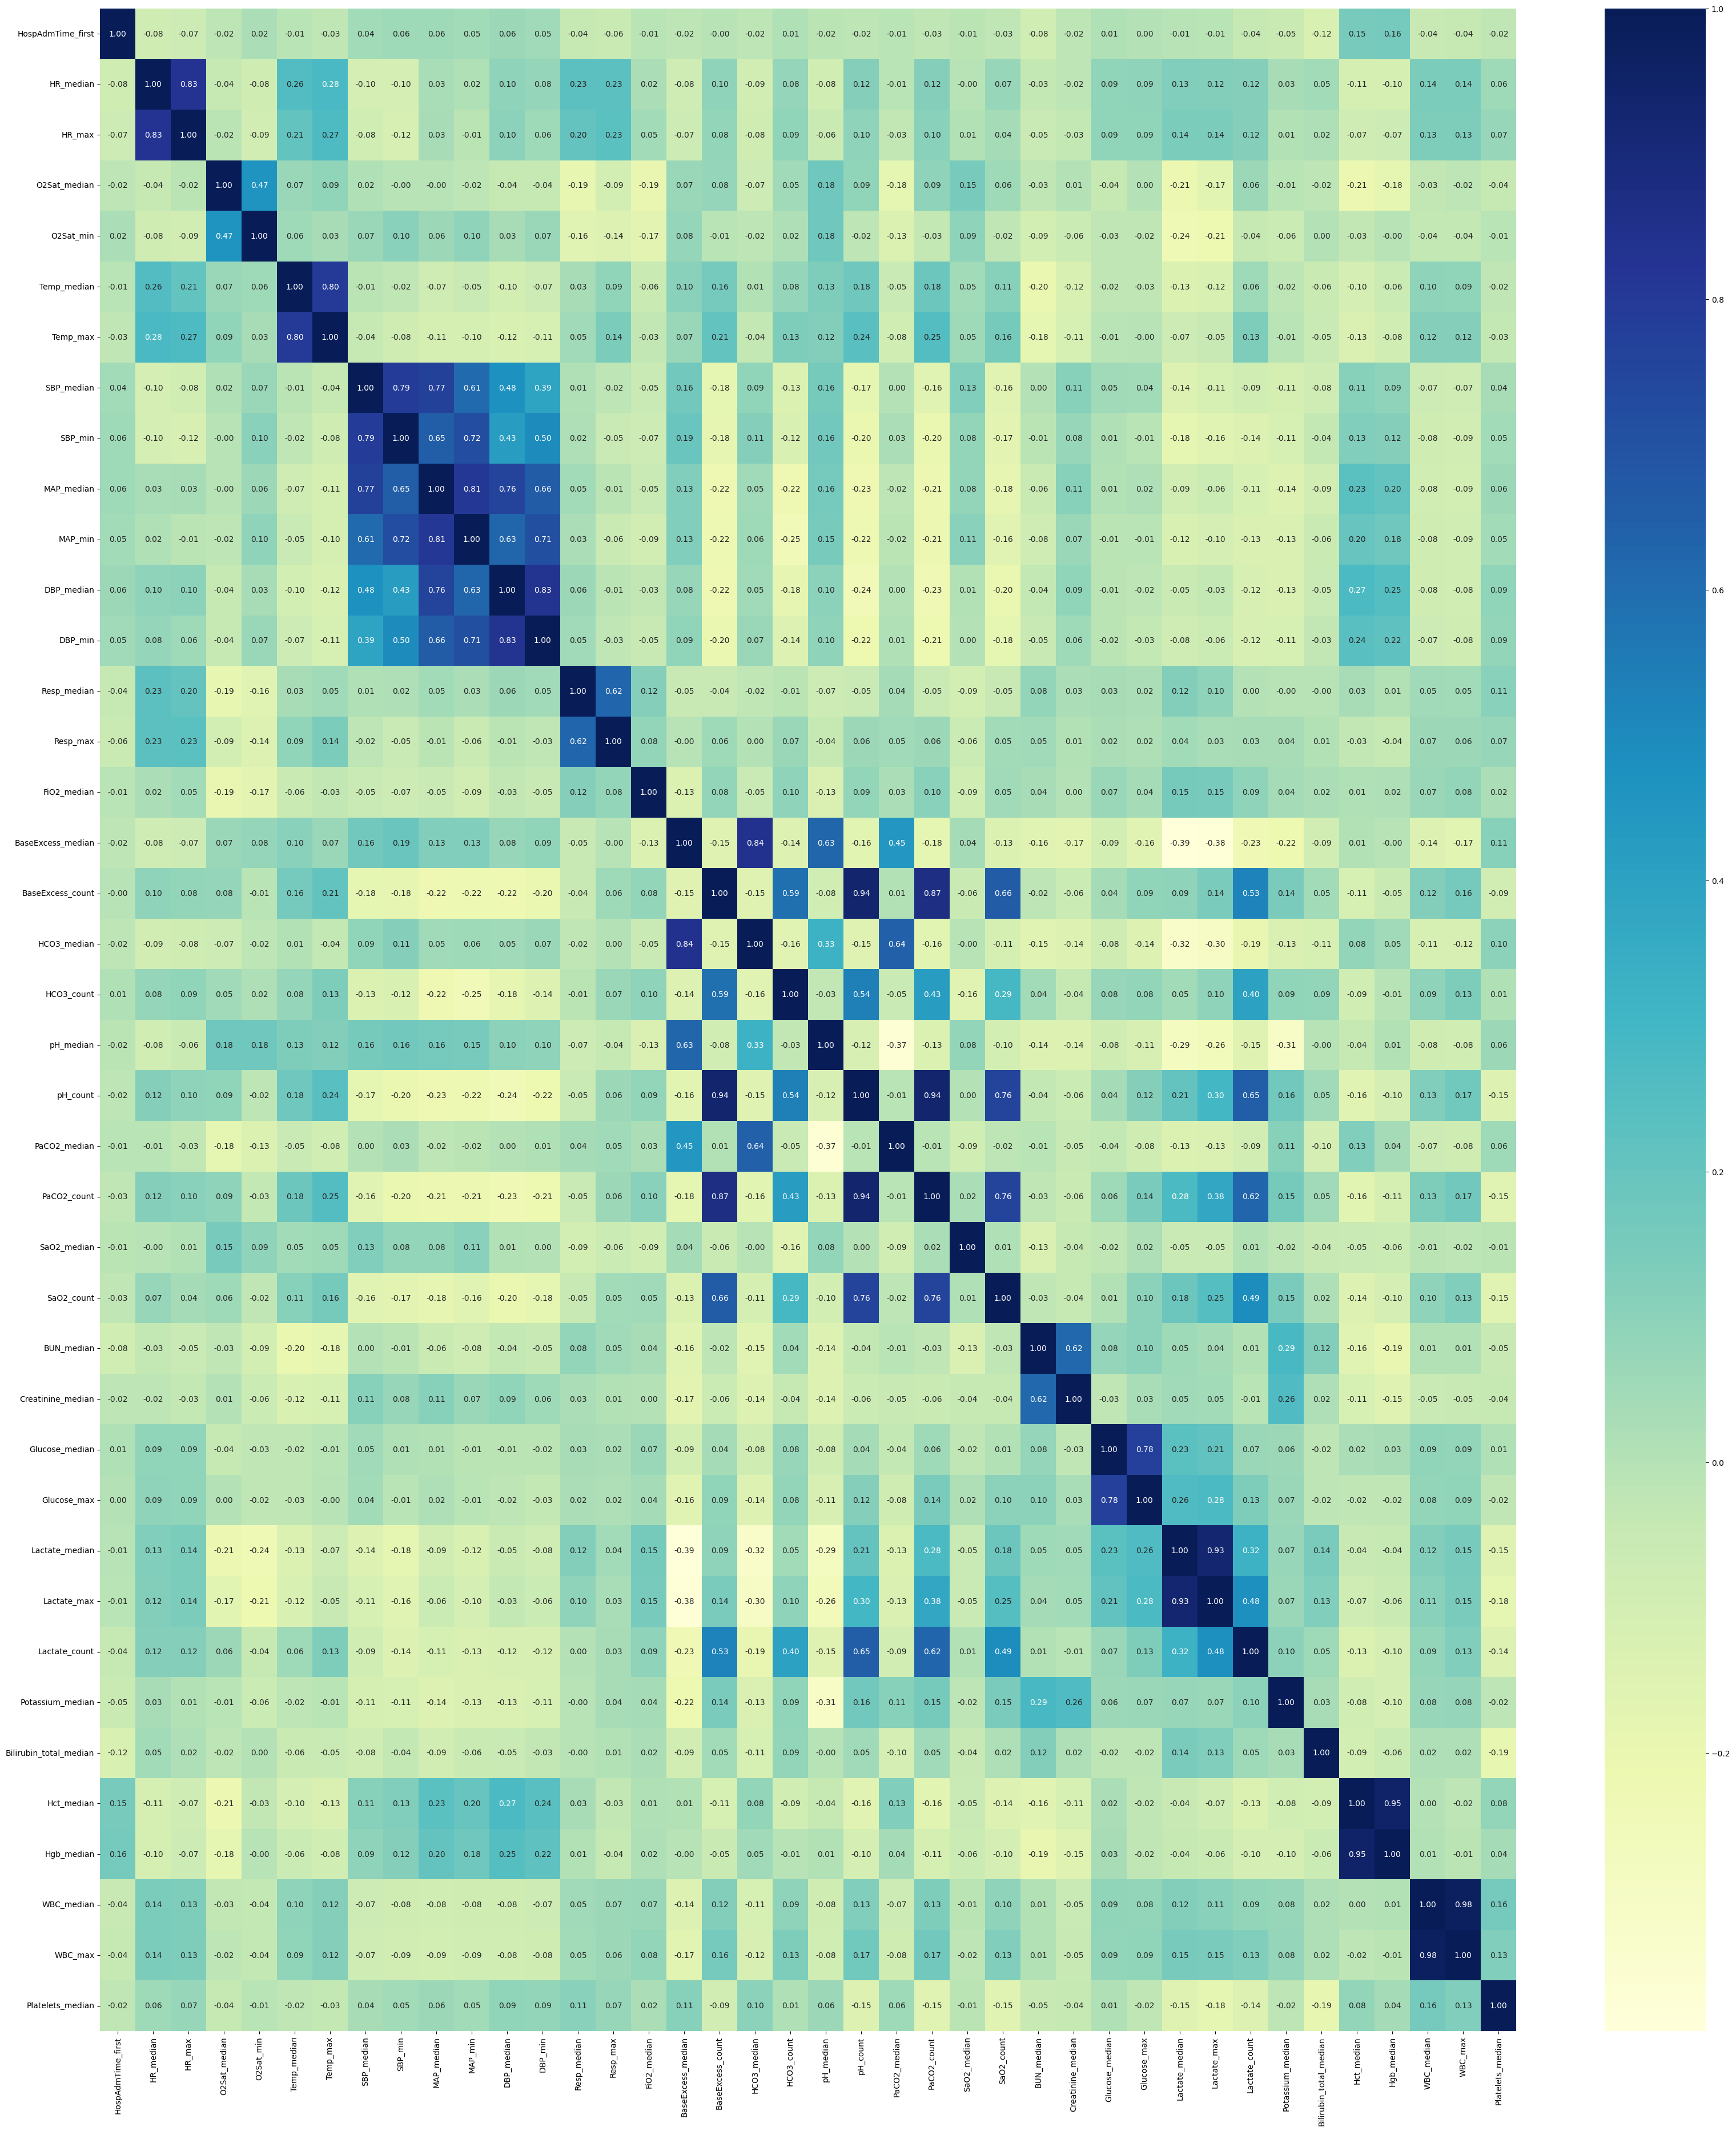

In [ ]:
numeric_columns = df_pretrain_clean.select_dtypes(include=['int64', 'float64']).columns

# correlation heatmap
plt.figure(figsize=(40,46))
correlation = df_pretrain_clean[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='YlGnBu')

Beberapa fitur perlu didrop karena adanya multikolinearitas dan membawa informasi yang sama, sehingga hanya menambah redundansi tanpa meningkatkan prediksi.

Hct_median dan Hgb_median berkorelasi ≈0,95 karena keduanya merepresentasikan komponen hematologi yang secara klinis dan matematis saling terkait, jadi cukup simpan salah satu.

WBC_median dengan WBC_max (0,98) serta Lactate_median dengan Lactate_max (0,93) menunjukkan fitur kembar, sehingga mempertahankan keduanya berisiko menambah noise/overfitting ringan, median dipilih karena lebih stabil.

BaseExcess_count dan pH_count sangat berkorelasi dengan PaCO2_count (0,94) karena semuanya sama-sama merefleksikan frekuensi pemeriksaan BGA, jadi cukup disimpan satu indikator count saja yaitu PaCO2_count.

In [ ]:
#Drop kolom Fitur multikolinearitas dan tidak ada mempengaruhi sepsis

multi_col = [
    "Hct_median",
    "WBC_max",
    "Lactate_max",
    "BaseExcess_count",
    "pH_count"
]

df_pretrain_clean = df_pretrain_clean.drop(columns=multi_col)
df_test_clean     = df_test_clean.drop(columns=multi_col)

In [ ]:
#Korelasi data kategorik dengan sepsis label

from scipy.stats import chi2_contingency


target_col = 'SepsisLabel'
categorical_cols = df_pretrain_clean.select_dtypes(include=['object']).columns

# Pastikan kolom target tidak ada di dalam daftar fitur yang akan diuji
if target_col in categorical_cols:
    categorical_cols = categorical_cols.drop(target_col)


results = []
for col in categorical_cols:
    table = pd.crosstab(df_pretrain_clean[col], df_pretrain_clean[target_col])

    # Hitung Chi-Square
    try:
        chi2, p, dof, ex = chi2_contingency(table)

        n = table.sum().sum()
        min_dim = min(table.shape) - 1
        if min_dim == 0 or n == 0:
            v = 0
        else:
            v = np.sqrt(chi2 / (n * min_dim))

        results.append({
            'Variabel': col,
            'Chi2 Statistic': chi2,
            'p-value': p,
            'Cramérs V': v
        })

    except ValueError:
        print(f"Melewatkan {col}: Error saat perhitungan (mungkin data kurang).")

# Ubah hasil menjadi DataFrame (tabel) agar mudah dibaca
df_results = pd.DataFrame(results)

# Urutkan hasilnya
# SANGAT DISARANKAN mengurutkan berdasarkan 'Cramérs V'
# Karena ini adalah ukuran kekuatan yang adil (nilai 0 s.d 1)
df_results = df_results.sort_values(by="Cramérs V", ascending=False)

print("\n--- HASIL ANALISIS ---")
print(df_results.to_string(index=False, float_format="%.4f"))


--- HASIL ANALISIS ---
    Variabel  Chi2 Statistic  p-value  Cramérs V
    ICU_Unit         95.1097   0.0000     0.0543
Gender_first         12.5973   0.0004     0.0198


Hasil uji Chi-square menunjukkan bahwa terdapat hubungan yang signifikan antara ICU_Unit dan kejadian sepsis, serta antara Gender_first dan kejadian sepsis (p < 0,05). Namun, kekuatan hubungannya termasuk lemah (Cramér’s V = 0,054 untuk ICU_Unit dan 0,020 untuk Gender_first)

In [ ]:
df_pretrain_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32256 entries, 31287 to 15795
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender_first            32256 non-null  object 
 1   HospAdmTime_first       32256 non-null  float64
 2   HR_median               32256 non-null  float64
 3   HR_max                  32256 non-null  float64
 4   O2Sat_median            32256 non-null  float64
 5   O2Sat_min               32256 non-null  float64
 6   Temp_median             32256 non-null  float64
 7   Temp_max                32256 non-null  float64
 8   SBP_median              32256 non-null  float64
 9   SBP_min                 32256 non-null  float64
 10  MAP_median              32256 non-null  float64
 11  MAP_min                 32256 non-null  float64
 12  DBP_median              32256 non-null  float64
 13  DBP_min                 32256 non-null  float64
 14  Resp_median             32256 non-null 

## **Feature Scalling**

In [ ]:
#OHE Gender_first dan ICU_Unit

df_pretrain_clean = pd.get_dummies(df_pretrain_clean, columns=['Gender_first', 'ICU_Unit'], drop_first=False,dtype=int)
df_test_clean = pd.get_dummies(df_test_clean, columns=['Gender_first', 'ICU_Unit'], drop_first=False,dtype=int)

In [ ]:
# Ubah nilai SepsisLabel dengan menggunakan replace

df_pretrain_clean['SepsisLabel'] = df_pretrain_clean['SepsisLabel'].replace({'No': 0, 'Yes': 1})
df_test_clean['SepsisLabel'] = df_test_clean['SepsisLabel'].replace({'No': 0, 'Yes': 1})

In [ ]:
df_pretrain_clean.head()

,HospAdmTime_first,HR_median,HR_max,O2Sat_median,O2Sat_min,Temp_median,Temp_max,SBP_median,SBP_min,MAP_median,MAP_min,DBP_median,DBP_min,Resp_median,Resp_max,FiO2_median,BaseExcess_median,HCO3_median,HCO3_count,pH_median,PaCO2_median,PaCO2_count,SaO2_median,SaO2_count,BUN_median,Creatinine_median,Glucose_median,Glucose_max,Lactate_median,Lactate_count,Potassium_median,Bilirubin_total_median,Hgb_median,WBC_median,Platelets_median,SepsisLabel,Gender_first_Female,Gender_first_Male,ICU_Unit_MICU,ICU_Unit_SICU,ICU_Unit_Unknown
31287,-51.74,91.75,120.0,100.0,95.0,36.475,36.7,130.5,99.0,92.50,72.0,69.25,54.0,13.5,30.0,0.4,NaN,NaN,0,7.445,30.4,2,98.3,2,11.0,0.77,137.0,180.0,2.825,2,4.21,NaN,10.30,11.1,75.0,0,1,0,0,1,0
35233,-3.92,96.25,127.5,99.5,81.0,35.900,36.9,114.5,83.0,70.25,55.0,57.25,48.0,18.0,28.0,1.0,NaN,NaN,0,7.140,44.6,5,98.4,5,34.0,3.24,124.0,316.0,15.540,5,4.28,0.1,7.65,1.9,57.5,0,1,0,1,0,0
16723,-4.37,75.00,115.0,98.0,94.0,36.300,37.1,130.5,104.0,84.00,67.0,65.00,53.0,14.0,25.0,0.6,-3.0,22.0,1,7.410,31.0,13,96.5,10,25.0,1.00,122.0,204.0,3.600,3,NaN,NaN,10.00,NaN,129.0,0,0,1,0,1,0
32024,-7.08,117.50,130.5,97.0,94.5,36.800,38.2,125.0,107.0,94.50,78.0,70.00,61.0,12.0,25.0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,9.0,0.45,110.0,110.0,NaN,0,3.60,2.8,6.90,3.8,16.5,0,1,0,1,0,0
31877,-152.17,88.00,107.0,100.0,94.0,36.900,37.4,102.0,84.0,75.00,63.0,60.00,52.0,16.0,19.0,0.4,NaN,NaN,0,7.320,40.3,1,98.4,1,12.0,0.81,137.0,194.0,3.430,1,4.19,NaN,10.50,12.4,194.0,0,1,0,0,1,0


## **Split Train dan Val**

In [ ]:
#split data

X_train = df_pretrain_clean.drop(columns=['SepsisLabel'])
y_train = df_pretrain_clean['SepsisLabel']

In [ ]:
X_test = df_test_clean.drop(columns=['SepsisLabel'])
y_test = df_test_clean['SepsisLabel']

In [ ]:
#pisah train sama val

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## **Modelling**

In [ ]:
#Model Building Decission Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score

def objective(trial):
    dt_params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',5, 30),
        'min_impurity_decrease': trial.suggest_float("min_impurity_decrease", 1e-10, 1e-3, log=True),
        'ccp_alpha': trial.suggest_float("ccp_alpha", 1e-10, 1e-2, log=True),
        'class_weight': 'balanced',
        'random_state': 42}

    #create and train
    dt = DecisionTreeClassifier(**dt_params)
    dt.fit(X_train, y_train)

    #Validation
    y_val_pred = dt.predict_proba(X_val)[:, 1]
    ap_dt = average_precision_score(y_val, y_val_pred)  # AUPRC
    return ap_dt

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

best_params_dt = study.best_params
best_ap_dt = study.best_value

print("Best Hyperparameters:", best_params_dt)
print("Best roc_auc:", study.best_value)

[I 2025-11-24 16:56:37,120] A new study created in memory with name: no-name-8c3a206b-f08d-489b-9738-9e3dba2e5743
[I 2025-11-24 16:56:37,164] Trial 0 finished with value: 0.13745803048317223 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 11, 'min_impurity_decrease': 3.855774015341727e-06, 'ccp_alpha': 0.0010450348257147113}. Best is trial 0 with value: 0.13745803048317223.
[I 2025-11-24 16:56:37,273] Trial 1 finished with value: 0.1582899360279288 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 10, 'min_impurity_decrease': 1.7373318369345132e-10, 'ccp_alpha': 3.813170709990837e-09}. Best is trial 1 with value: 0.1582899360279288.
[I 2025-11-24 16:56:37,317] Trial 2 finished with value: 0.1470897891034411 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'log2', 'm

Best Hyperparameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.00015704676474690194, 'ccp_alpha': 1.1771474646866966e-10}
Best roc_auc: 0.17061746539824912


In [ ]:
#Model Building Random Forest

from sklearn.ensemble import RandomForestClassifier

# Objective function for Optuna optimization
def objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 30),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
        "bootstrap": True,
        "max_samples": trial.suggest_float("max_samples", 0.6, 0.9),
        "n_jobs": -1,
        "random_state": 42
    }

    #Create and train
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)

    #Validation
    y_val_pred = rf.predict_proba(X_val)[:, 1]
    ap_rf = average_precision_score(y_val, y_val_pred)  # AUPRC
    return ap_rf

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params_rf = study.best_params
best_ap_rf = study.best_value

[I 2025-11-24 17:09:14,761] A new study created in memory with name: no-name-36dd3965-e1bd-4267-a895-927c1a163730
[I 2025-11-24 17:09:33,232] Trial 0 finished with value: 0.20236097282432533 and parameters: {'n_estimators': 316, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 21, 'class_weight': 'balanced_subsample', 'max_samples': 0.8802799488964976}. Best is trial 0 with value: 0.20236097282432533.
[I 2025-11-24 17:10:23,667] Trial 1 finished with value: 0.23547747263369867 and parameters: {'n_estimators': 323, 'criterion': 'gini', 'max_features': 0.5, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 30, 'class_weight': 'balanced_subsample', 'max_samples': 0.8256741022969887}. Best is trial 1 with value: 0.23547747263369867.
[I 2025-11-24 17:10:32,957] Trial 2 finished with value: 0.2376476927531047 and parameters: {'n_estimators': 260, 'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_sp

Penggunaan Parameter

- bootstrap=True: tiap pohon dilatih dari sampel data acak (boleh ada data yang terulang). Ini membuat tiap pohon beda-beda sehingga ensemble lebih kuat.
- max_samples: mengatur berapa banyak data yang dipakai per pohon (mis. 0.7 = 70% data).Semakin kecil max samples maka Pohon semakin beragam dan overfitting semakin turun.

In [ ]:
#Model BUilding XGBOOST

from xgboost import XGBClassifier, callback
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / pos


# Objective function for Optuna optimization
def objective(trial):
    xgb_params = {
        "n_estimators": 5000,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 4),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 40),
        "gamma": trial.suggest_float("gamma", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 5.0, 50.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 5),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "scale_pos_weight": spw,
        "random_state": 42,
        "eval_metric": "aucpr",
        "n_jobs": -1,
        "tree_method": "hist"
    }

    # pastikan kolom val urutannya sama
    X_val_aligned = X_val.reindex(columns=X_train.columns, fill_value=float("nan"))


    # early stopping callback dipasang di constructor
    early_stop = callback.EarlyStopping(rounds=100, save_best=True)

    #Create and train
    xgb = XGBClassifier(**xgb_params, callbacks=[early_stop])
    xgb.fit(X_train, y_train,
        eval_set=[(X_val_aligned, y_val)],
        verbose=False)

    #Validation
    y_val_pred = xgb.predict_proba(X_val_aligned)[:, 1]
    ap = average_precision_score(y_val, y_val_pred)  # AUPRC
    return ap

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

best_params = study.best_params
best_ap = study.best_value

print("Best Hyperparameters:", best_params)
print("Best AUPRC:", best_ap)


[I 2025-11-24 16:17:20,200] A new study created in memory with name: no-name-a330f794-091d-45be-af60-3eef184d1250
[I 2025-11-24 16:18:08,910] Trial 0 finished with value: 0.27674507808457544 and parameters: {'learning_rate': 0.013335996671127281, 'max_depth': 2, 'min_child_weight': 24, 'gamma': 2.9559778039841142, 'subsample': 0.7690816496009927, 'colsample_bytree': 0.81260682896916, 'reg_alpha': 0.774955801838868, 'reg_lambda': 21.683293411063573, 'max_delta_step': 1, 'colsample_bynode': 0.9076653672502288}. Best is trial 0 with value: 0.27674507808457544.
[I 2025-11-24 16:18:39,456] Trial 1 finished with value: 0.2690714750199675 and parameters: {'learning_rate': 0.010797093172482543, 'max_depth': 2, 'min_child_weight': 32, 'gamma': 6.95445306194046, 'subsample': 0.7054478254316772, 'colsample_bytree': 0.8469983680853945, 'reg_alpha': 1.9141865642876754, 'reg_lambda': 37.35541454160643, 'max_delta_step': 1, 'colsample_bynode': 0.8787071128695898}. Best is trial 0 with value: 0.276745

Best Hyperparameters: {'learning_rate': 0.018504725282124747, 'max_depth': 4, 'min_child_weight': 23, 'gamma': 6.943504984022571, 'subsample': 0.609691282078786, 'colsample_bytree': 0.8290117756826254, 'reg_alpha': 3.720442618233255, 'reg_lambda': 25.95061971811944, 'max_delta_step': 2, 'colsample_bynode': 0.8501581724265488}
Best AUPRC: 0.28663152287900456


Penggunaan Parameter

- max_delta_step: “rem” buat update model. Membuat perubahan tiap langkah kecil supaya model tidak terlalu agresif dan lebih stabil, terutama saat kelas sepsis sedikit.
- colsample_bynode: tiap split di pohon cuma lihat sebagian fitur secara acak. Tujuannya supaya model tidak terlalu bergantung ke fitur tertentu dan mengurangi overfitting.

## **Evaluasi Model**

### **Decision Tree**

**Before Tuning**

In [ ]:
# Model Building: Decision Tree Train before tuning

dt_before = DecisionTreeClassifier().fit(X_train, y_train)

y_train_probdt_before = dt_before.predict_proba(X_train)[:, 1]
dt_before_auprc_train = average_precision_score(y_train, y_train_probdt_before)

print("AUPRC Score (Train):", dt_before_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = dt_before.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr_dt = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr_dt)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_preddt = (y_train_probdt_before >= best_thr_dt).astype(int)

print("Classification Report decission tree (Train):")
print(classification_report(y_train, y_train_preddt))

AUPRC Score (Train): 0.9932865263674725
Best threshold from val: 1.0
Classification Report decission tree (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23955
           1       1.00      1.00      1.00      1849

    accuracy                           1.00     25804
   macro avg       1.00      1.00      1.00     25804
weighted avg       1.00      1.00      1.00     25804



In [ ]:
#model Decision Tree test before tuning
y_test_probdt_before = dt_before.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_preddt = (y_test_probdt_before >= best_thr_dt).astype(int)

# AUPRC test (tetap dari probabilitas)
dt_before_auprc_test = average_precision_score(y_test, y_test_probdt_before)
print("AUPRC Score (Test):", dt_before_auprc_test)

print("Classification Report decission Tree (Test):")
print(classification_report(y_test, y_test_preddt))

AUPRC Score (Test): 0.09382925686524263
Classification Report decission Tree (Test):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7484
           1       0.17      0.21      0.19       581

    accuracy                           0.87      8065
   macro avg       0.56      0.57      0.56      8065
weighted avg       0.88      0.87      0.88      8065



**After Tuning**

In [ ]:
# Model Building Decision Tree Train after tuning

dt_after = DecisionTreeClassifier(**best_params_dt).fit(X_train, y_train)

y_train_prob = dt_after.predict_proba(X_train)[:, 1]
dt_after_auprc_train = average_precision_score(y_train, y_train_prob)

print("AUPRC Score (Train):", dt_after_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = dt_after.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_preddt = (y_train_prob >= best_thr).astype(int)

print("Classification Report decission tree (Train):")
print(classification_report(y_train, y_train_preddt))

AUPRC Score (Train): 0.2537583851784501
Best threshold from val: 0.0995850622406639
Classification Report decission tree (Train):
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     23955
           1       0.19      0.68      0.29      1849

    accuracy                           0.76     25804
   macro avg       0.58      0.73      0.58     25804
weighted avg       0.91      0.76      0.82     25804



In [ ]:
#model Decision Tree test after tuning
y_test_prob = dt_after.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_preddt = (y_test_prob >= best_thr).astype(int)

# AUPRC test (tetap dari probabilitas)
dt_after_auprc_test = average_precision_score(y_test, y_test_prob)
print("AUPRC Score (Test):", dt_after_auprc_test)

print("Classification Report decission Tree (Test):")
print(classification_report(y_test, y_test_preddt))

AUPRC Score (Test): 0.1559116407028341
Classification Report decission Tree (Test):
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      7484
           1       0.16      0.58      0.25       581

    accuracy                           0.74      8065
   macro avg       0.56      0.67      0.55      8065
weighted avg       0.90      0.74      0.80      8065



In [ ]:
#confusion matrix

from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_preddt)

print(cm)

[[5660 1824]
 [ 242  339]]


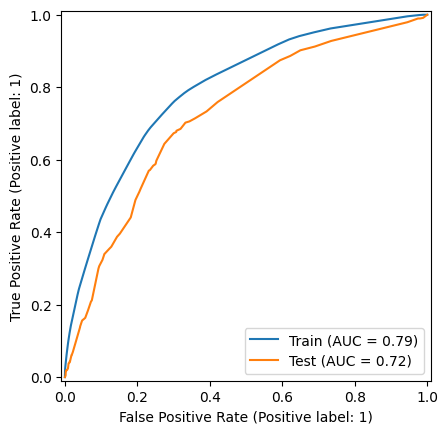

In [ ]:
#curve roc auc train and test after tuning
from sklearn.metrics import RocCurveDisplay

auc_train = RocCurveDisplay.from_estimator(
  dt_after,
  X_train,
  y_train,
  name='Train',
)

RocCurveDisplay.from_estimator(
  dt_after,
  X_test,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

## **Random Forest**

**Before Tuning**

In [ ]:
# Model Building: Random Forest Train before tuning

rf_before = RandomForestClassifier().fit(X_train, y_train)

y_train_probrf_before = rf_before.predict_proba(X_train)[:, 1]
rf_before_auprc_train = average_precision_score(y_train, y_train_probrf_before)

print("AUPRC Score (Train):", rf_before_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = rf_before.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr_rf = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr_rf)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_predrf = (y_train_probrf_before >= best_thr_rf).astype(int)

print("Classification Report random forest (Train):")
print(classification_report(y_train, y_train_predrf))

AUPRC Score (Train): 1.0
Best threshold from val: 0.2
Classification Report random forest (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23955
           1       0.99      1.00      0.99      1849

    accuracy                           1.00     25804
   macro avg       0.99      1.00      1.00     25804
weighted avg       1.00      1.00      1.00     25804



In [ ]:
#model random forest test before tuning
y_test_probrf_before = rf_before.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_predrf = (y_test_probrf_before >= best_thr_rf).astype(int)

# AUPRC test (tetap dari probabilitas)
rf_before_auprc_test = average_precision_score(y_test, y_test_probrf_before)
print("AUPRC Score (Test):", rf_before_auprc_test)

print("Classification Report random forest (Test):")
print(classification_report(y_test, y_test_predrf))

AUPRC Score (Test): 0.20542043938221208
Classification Report random forest (Test):
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      7484
           1       0.24      0.40      0.30       581

    accuracy                           0.87      8065
   macro avg       0.60      0.65      0.61      8065
weighted avg       0.90      0.87      0.88      8065



**After Tuning**

In [ ]:
# Model Building random forest Train after tuning

rf_after = RandomForestClassifier(**best_params_rf).fit(X_train, y_train)

y_train_prob = rf_after.predict_proba(X_train)[:, 1]
rf_after_auprc_train = average_precision_score(y_train, y_train_prob)

print("AUPRC Score (Train):", rf_after_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = rf_after.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_predrf = (y_train_prob >= best_thr).astype(int)

print("Classification Report Random Forest (Train):")
print(classification_report(y_train, y_train_predrf))

AUPRC Score (Train): 0.873824917171302
Best threshold from val: 0.1458404210536654
Classification Report Random Forest (Train):
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     23955
           1       0.46      0.93      0.61      1849

    accuracy                           0.92     25804
   macro avg       0.73      0.92      0.78     25804
weighted avg       0.96      0.92      0.93     25804



In [ ]:
#model Random Forest test after tuning
y_test_prob = rf_after.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_predrf = (y_test_prob >= best_thr).astype(int)

# AUPRC test (tetap dari probabilitas)
rf_after_auprc_test = average_precision_score(y_test, y_test_prob)
print("AUPRC Score (Test):", rf_after_auprc_test)

print("Classification Report decission Tree (Test):")
print(classification_report(y_test, y_test_predrf))

AUPRC Score (Test): 0.24440966318326
Classification Report decission Tree (Test):
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      7484
           1       0.23      0.53      0.32       581

    accuracy                           0.84      8065
   macro avg       0.60      0.70      0.62      8065
weighted avg       0.91      0.84      0.87      8065



In [ ]:
#confusion matrix xgb

from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_predrf)

print(cm)

[[6451 1033]
 [ 271  310]]


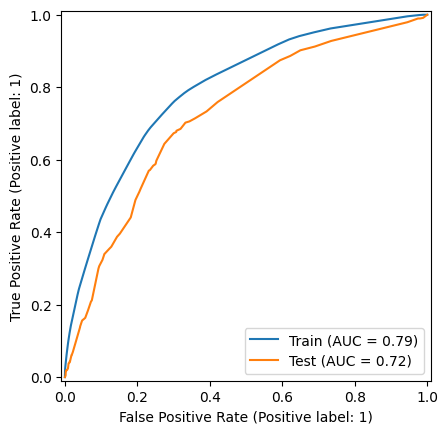

In [ ]:
#curve roc auc train and test after tuning
from sklearn.metrics import RocCurveDisplay

auc_train = RocCurveDisplay.from_estimator(
  dt_after,
  X_train,
  y_train,
  name='Train',
)

RocCurveDisplay.from_estimator(
  dt_after,
  X_test,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

### **XGBOOST**

**Before Tuning**

In [ ]:
# Model Building: XGBOOST Train before tuning

xgb_before = XGBClassifier().fit(X_train, y_train)

y_train_probxgb_before = xgb_before.predict_proba(X_train)[:, 1]
xgb_before_auprc_train = average_precision_score(y_train, y_train_probxgb_before)

print("AUPRC Score (Train):", xgb_before_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = xgb_before.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr_xgb = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr_xgb)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_predxgb = (y_train_probxgb_before >= best_thr_xgb).astype(int)

print("Classification Report XGBOOST (Train):")
print(classification_report(y_train, y_train_predxgb))

AUPRC Score (Train): 0.9848440884988544
Best threshold from val: 0.09802054
Classification Report XGBOOST (Train):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     23955
           1       0.60      0.98      0.75      1849

    accuracy                           0.95     25804
   macro avg       0.80      0.97      0.86     25804
weighted avg       0.97      0.95      0.96     25804



In [ ]:
#model XGBOOST test before tuning
y_test_probxgb_before = xgb_before.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_predxgb = (y_test_probxgb_before >= best_thr_xgb).astype(int)

# AUPRC test (tetap dari probabilitas)
xgb_before_auprc_test = average_precision_score(y_test, y_test_probxgb_before)
print("AUPRC Score (Test):", xgb_before_auprc_test)

print("Classification Report XGBOOST (Test):")
print(classification_report(y_test, y_test_predxgb))

AUPRC Score (Test): 0.2276799927808155
Classification Report XGBOOST (Test):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7484
           1       0.21      0.44      0.28       581

    accuracy                           0.84      8065
   macro avg       0.58      0.66      0.60      8065
weighted avg       0.90      0.84      0.87      8065



**After Tuning**

In [ ]:
#model Xboost train after tuning
from sklearn.metrics import precision_recall_curve

xgb_after = XGBClassifier(**best_params).fit(X_train, y_train)

y_train_prob = xgb_after.predict_proba(X_train)[:, 1]
xgb_after_auprc_train = average_precision_score(y_train, y_train_prob)

print("AUPRC Score (Train):", xgb_after_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = xgb_after.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_pred = (y_train_prob >= best_thr).astype(int)

print("Classification Report Xgboost (Train):")
print(classification_report(y_train, y_train_pred))

AUPRC Score (Train): 0.2425179642789735
Best threshold from val: 0.103905804
Classification Report Xgboost (Train):
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     23955
           1       0.22      0.58      0.32      1849

    accuracy                           0.83     25804
   macro avg       0.59      0.71      0.61     25804
weighted avg       0.91      0.83      0.86     25804



In [ ]:
#model xgboost test after tuning
y_test_prob = xgb_after.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_pred = (y_test_prob >= best_thr).astype(int)

# AUPRC test (tetap dari probabilitas)
xgb_after_auprc_test = average_precision_score(y_test, y_test_prob)
print("AUPRC Score (Test):", xgb_after_auprc_test)

print("Classification Report Xgboost (Test):")
print(classification_report(y_test, y_test_pred))

AUPRC Score (Test): 0.2122085792831916
Classification Report Xgboost (Test):
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7484
           1       0.21      0.55      0.30       581

    accuracy                           0.82      8065
   macro avg       0.59      0.70      0.60      8065
weighted avg       0.91      0.82      0.85      8065



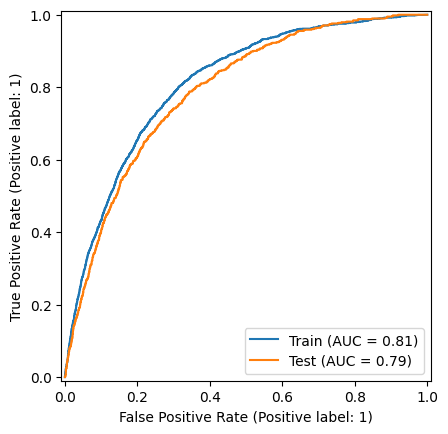

In [ ]:
#curve roc auc train and test after tuning
from sklearn.metrics import RocCurveDisplay

auc_train = RocCurveDisplay.from_estimator(
  xgb_after,
  X_train,
  y_train,
  name='Train',
)

RocCurveDisplay.from_estimator(
  xgb_after,
  X_test,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

- Test AUPRC = 0.212 vs baseline 0.07 shows (sepsis prevalence) shows a clear early-warning signal: the model is roughly 3x better than random at ranking patients by sepsis risk. ROC-AUC = 0.79 (train 0.81, test 0.79) indicates good overall discrimination using only the first 24 hours of ICU data.

- With the tuned threshold 0.104, the model achieves recall ≈ 0.55 for sepsis (captures more than half of sepsis cases early) and precision ≈ 0.21 (around 1 in 5 alerts is a true sepsis case), which is expected for a sensitive early-warning tool.

- The gap between train and test is small (AUPRC 0.24 → 0.21; ROC-AUC 0.81 → 0.79), suggesting only mild overfitting and reasonable generalisation to unseen ICU patients.



In [ ]:
#confusion matrix xgb

from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

print(cm)

[[6277 1207]
 [ 260  321]]


- The model detects about 55% of sepsis cases in the first 24 hours, which is consistent with its role as an early-warning tool rather than a diagnostic test.

- False alarms are still high (878 FP vs 294 TP) and will require clinical triage.

- Missed sepsis remains substantial (260 FN). The model should not be used as a stand-alone decision maker.

## **Feature Importance**

In [ ]:
# Initialize Explainer for all models

## initiate explainer for XGBoost model
sepsis_xgb_exp = dx.Explainer(xgb_after, X_train, y_train, label="XGBoost Interpretation")

Preparation of a new explainer is initiated

  -> data              : 25804 rows 40 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 25804 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost Interpretation
  -> predict function  : <function yhat_proba_default at 0x78e91e5c0d60> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0289, mean = 0.0693, max = 0.254
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.246, mean = 0.00231, max = 0.971
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
# visualize permutation feature importance for XGBoost model
sepsis_xgb_exp.model_parts().plot()

In [ ]:
# create partial dependence plot of XGBoost model
sepsis_xgb_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


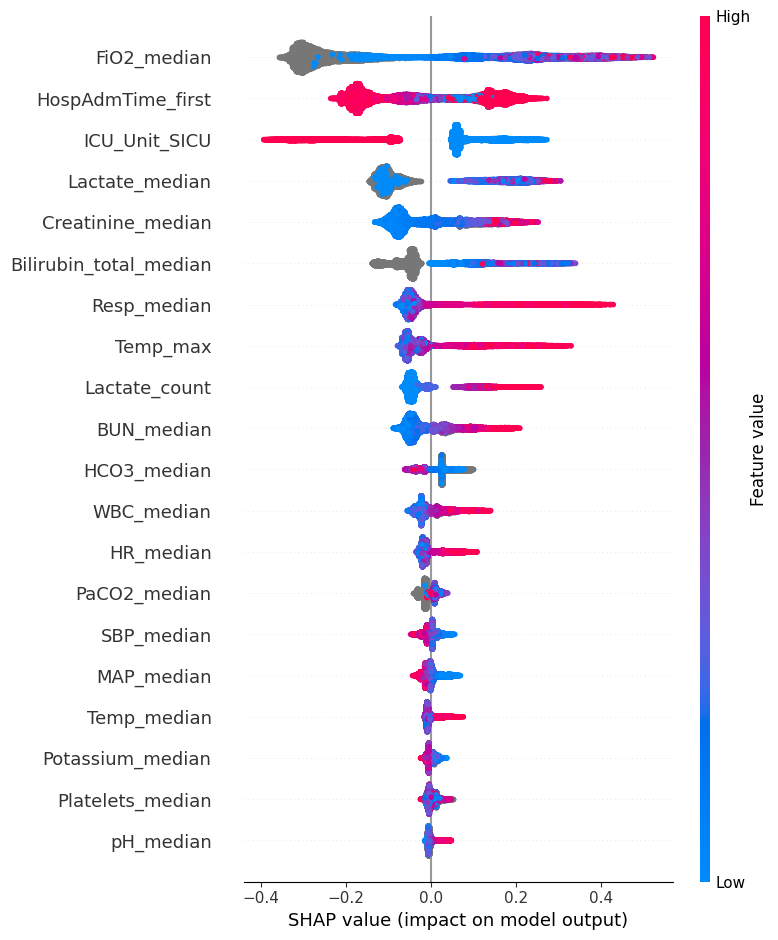

In [ ]:
import xgboost # Ensure xgboost is imported

# Convert X_train columns to a list for feature_names
dtrain = xgboost.DMatrix(X_train, feature_names=list(getattr(X_train, 'columns', None)))
booster = xgb_after.get_booster()

contribs = booster.predict(dtrain, pred_contribs=True, approx_contribs=False)
shap_values = contribs[:, :-1]      # (n_samples, n_features)
expected_values = contribs[:, -1]   # (n_samples,)

exp = shap.Explanation(
    values=shap_values,
    base_values=expected_values,
    data=np.array(X_train),
    feature_names=list(getattr(X_train,'columns', map(str, range(shap_values.shape[1]))))
)
shap.summary_plot(exp.values, exp.data, feature_names=exp.feature_names)


- The most influential features are FiO2_median, HospAdmTime_first, ICU_Unit_SICU, Lactate_median, Creatinine_median, and Bilirubin_total_median.
- Higher values of FiO₂, lactate, creatinine, respiratory rate and temperature show positive SHAP values, indicating higher predicted sepsis risk.
- Being admitted to SICU (ICU_Unit_SICU = 1) is also associated with increased model-predicted risk compared with other ICU units.



**Conclusion**
This project shows that sepsis risk in ICU patients can be predicted from routine data in the first 24 hours using an XGBoost model with reasonable discrimination (AUPRC clearly above baseline). Higher FiO₂, SICU admission, longer pre-ICU hospital stay, abnormal vital signs, metabolic acidosis, and organ-dysfunction markers (lactate, creatinine, bilirubin, BUN) emerge as the strongest early risk signals.

**Future directions**
- For hospitals: Implement the model as an early-warning decision support tool (not an automatic diagnosis) and define clear clinical response pathways for high-risk alerts.
- For the model: It can be improved by adding richer information (key medication/procedure data) so that predictions become more accurate and clinically meaningful. The model can also be integrated with the hospital system so clinicians can give feedback on alerts, and this feedback is used to continuously refine the model.

In [ ]:
import joblib

final_features = X_train.columns.tolist()   # urutan fitur yg dipakai model

artifact = {
    "features": final_features,
    "model": xgb_after,     # model final yang sudah train
    "best_thr": float(0.103905804)  # threshold dari val
}

joblib.dump(artifact, "sepsis_xgb_artifact.pkl")
print("Saved artifact")

Saved artifact
